In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from conformal_region_designer.case_studies.car_experiments import CarEnvironment, generate_calibration_dataset, generate_train_dataset, TrajectoryPredictor
from conformal_region_designer.utils import set_square_aspect_ratio, shuffle_split_testing, conformalized_quantile

In [3]:
import random
random.seed(42)
np.random.seed(42)
train_X, train_Y = generate_train_dataset(100)
env_X, env_Y = generate_calibration_dataset(10_000)

In [4]:
predictor = TrajectoryPredictor(0.1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Text(0.5, 0.98, 'Training Trajectories')

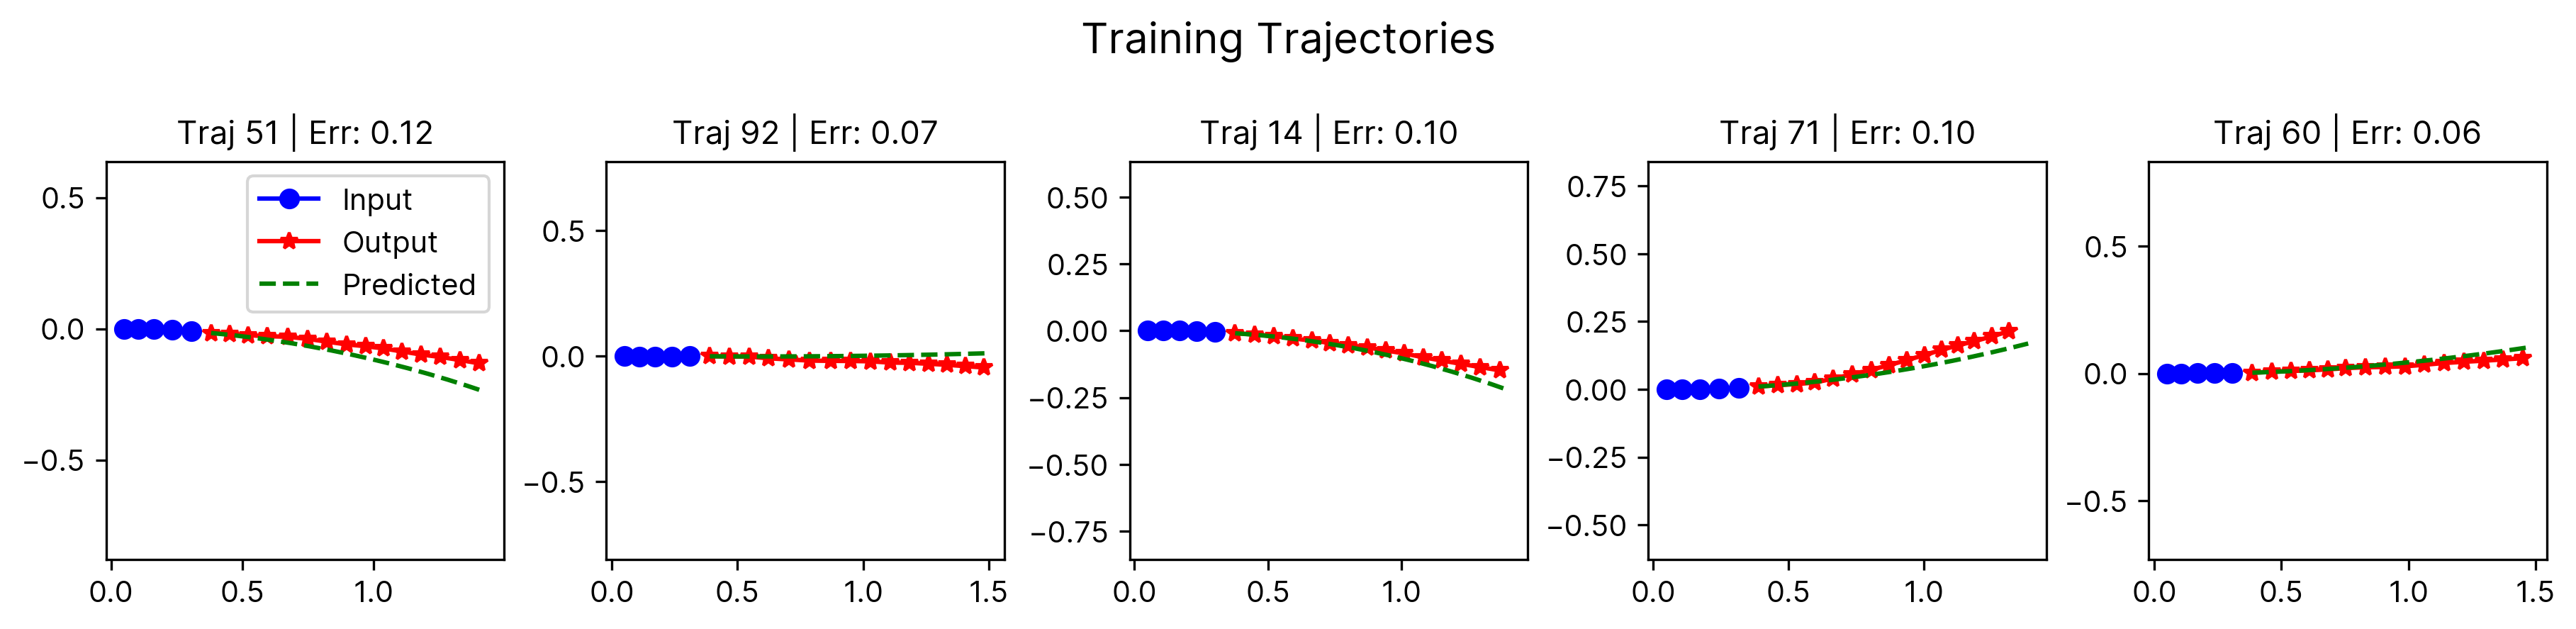

In [5]:
INDEX = np.random.choice(train_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(train_X[INDEX[i], :, 0], train_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(train_Y[INDEX[i], :, 0], train_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(train_X[INDEX[i]])
    error = np.linalg.norm(prediction - train_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
plt.suptitle('Training Trajectories')

Text(0.5, 0.98, 'Calibration Distribution')

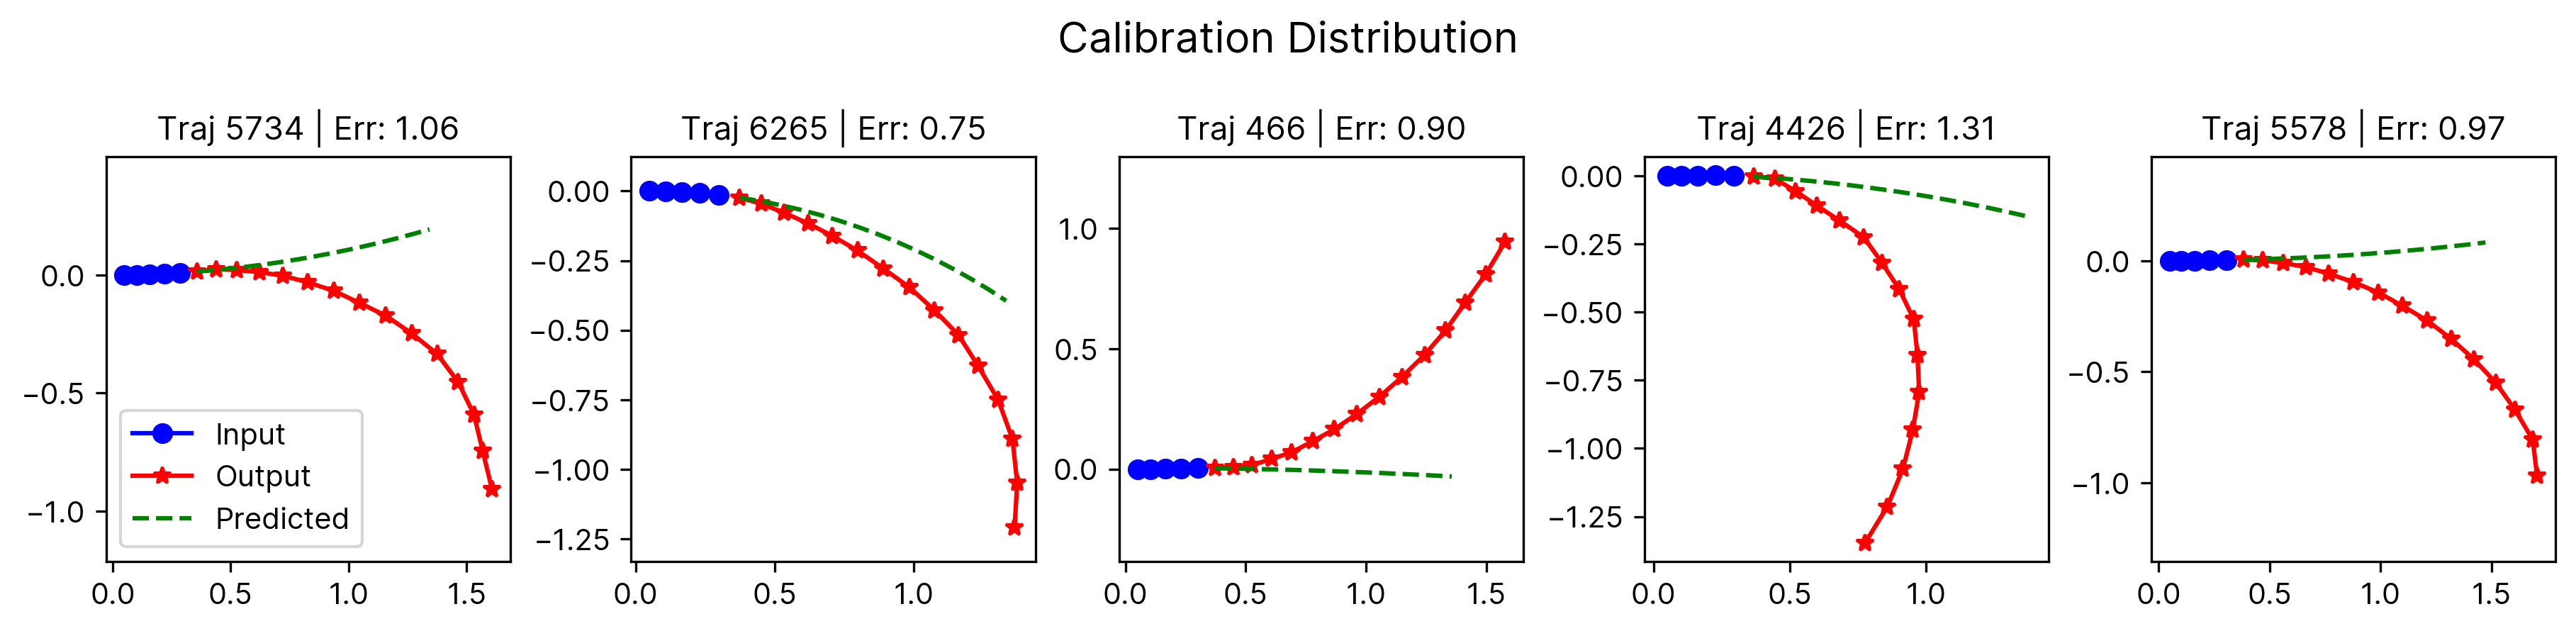

In [6]:
INDEX = np.random.choice(env_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Calibration Distribution')

In [7]:
env_Y_hat = predictor.predict_batched_trajectories(env_X)
Z_env = env_Y[:,-1,:2] - env_Y_hat[:,-1,:2]
np.random.shuffle(Z_env)

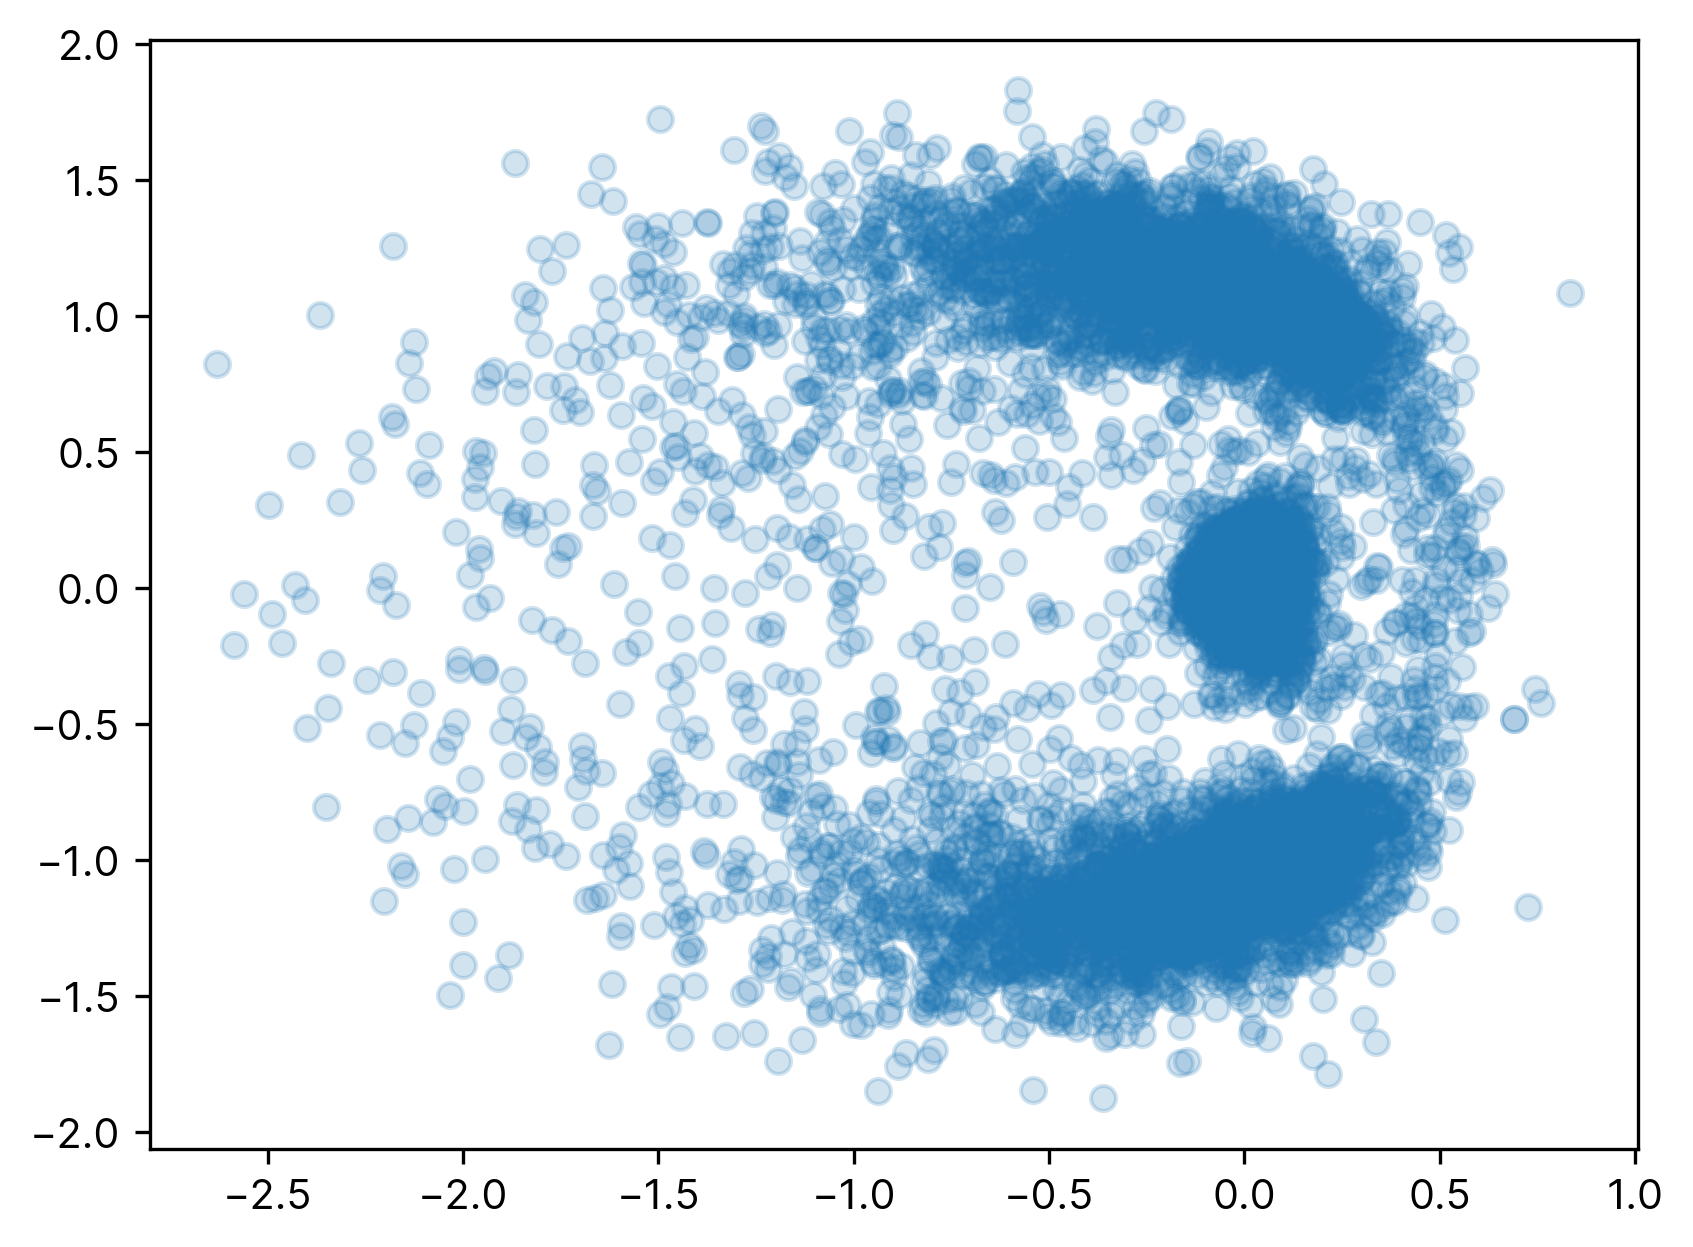

In [8]:
plt.scatter(Z_env[:,0], Z_env[:,1], alpha=0.2)

# Use Parametrized Conformal Regions for Prediction

In [9]:
from conformal_region_designer.conformity_optimizer import ConformalRegion
DELTA = 0.90
BW_FACTOR = 0.4

In [10]:
Z_cal_one = Z_env[:Z_env.shape[0]//3]
Z_cal_two = Z_env[Z_env.shape[0]//3:2*(Z_env.shape[0]//3)]
Z_test = Z_env[2*(Z_env.shape[0]//3):]
Z_eval = Z_env[(Z_env.shape[0]//3):]
print(Z_cal_one.shape, Z_cal_two.shape, Z_test.shape)

(3333, 2) (3333, 2) (3334, 2)


In [11]:
## Calculate benchmark CP region, based on L2 norm
bcp_scores_cal_one = np.linalg.norm(Z_cal_one, axis=1)
bcp_scores_cal_two = np.linalg.norm(Z_cal_two, axis=1)
bcp_scores_cal = np.concatenate([bcp_scores_cal_one, bcp_scores_cal_two])
bcp_scores_test = np.linalg.norm(Z_test, axis=1)
bcp_conformal_quantile = conformalized_quantile(len(bcp_scores_cal), DELTA)
bcp_conformal_bound = np.quantile(bcp_scores_cal, bcp_conformal_quantile)
print(f'Conformal Quantile: {bcp_conformal_quantile:.2f}')
test_coverage = (bcp_scores_test < bcp_conformal_bound).mean()
print(f'Coverage on test set: {test_coverage:.4f}')
print(f'Conformal Bound: {bcp_conformal_bound:.2f} | Area: {np.pi * bcp_conformal_bound**2:.2f}')

Conformal Quantile: 0.90
Coverage on test set: 0.9061
Conformal Bound: 1.44 | Area: 6.54


## Convex Hull

In [12]:
from conformal_region_designer.density_estimation import KDE
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegion(de, "meanshift", "convexhull", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
cvxpcr = pcr

Total Weight Sum: 0.9867109337192436


Test Coverage:  0.8950209958008398


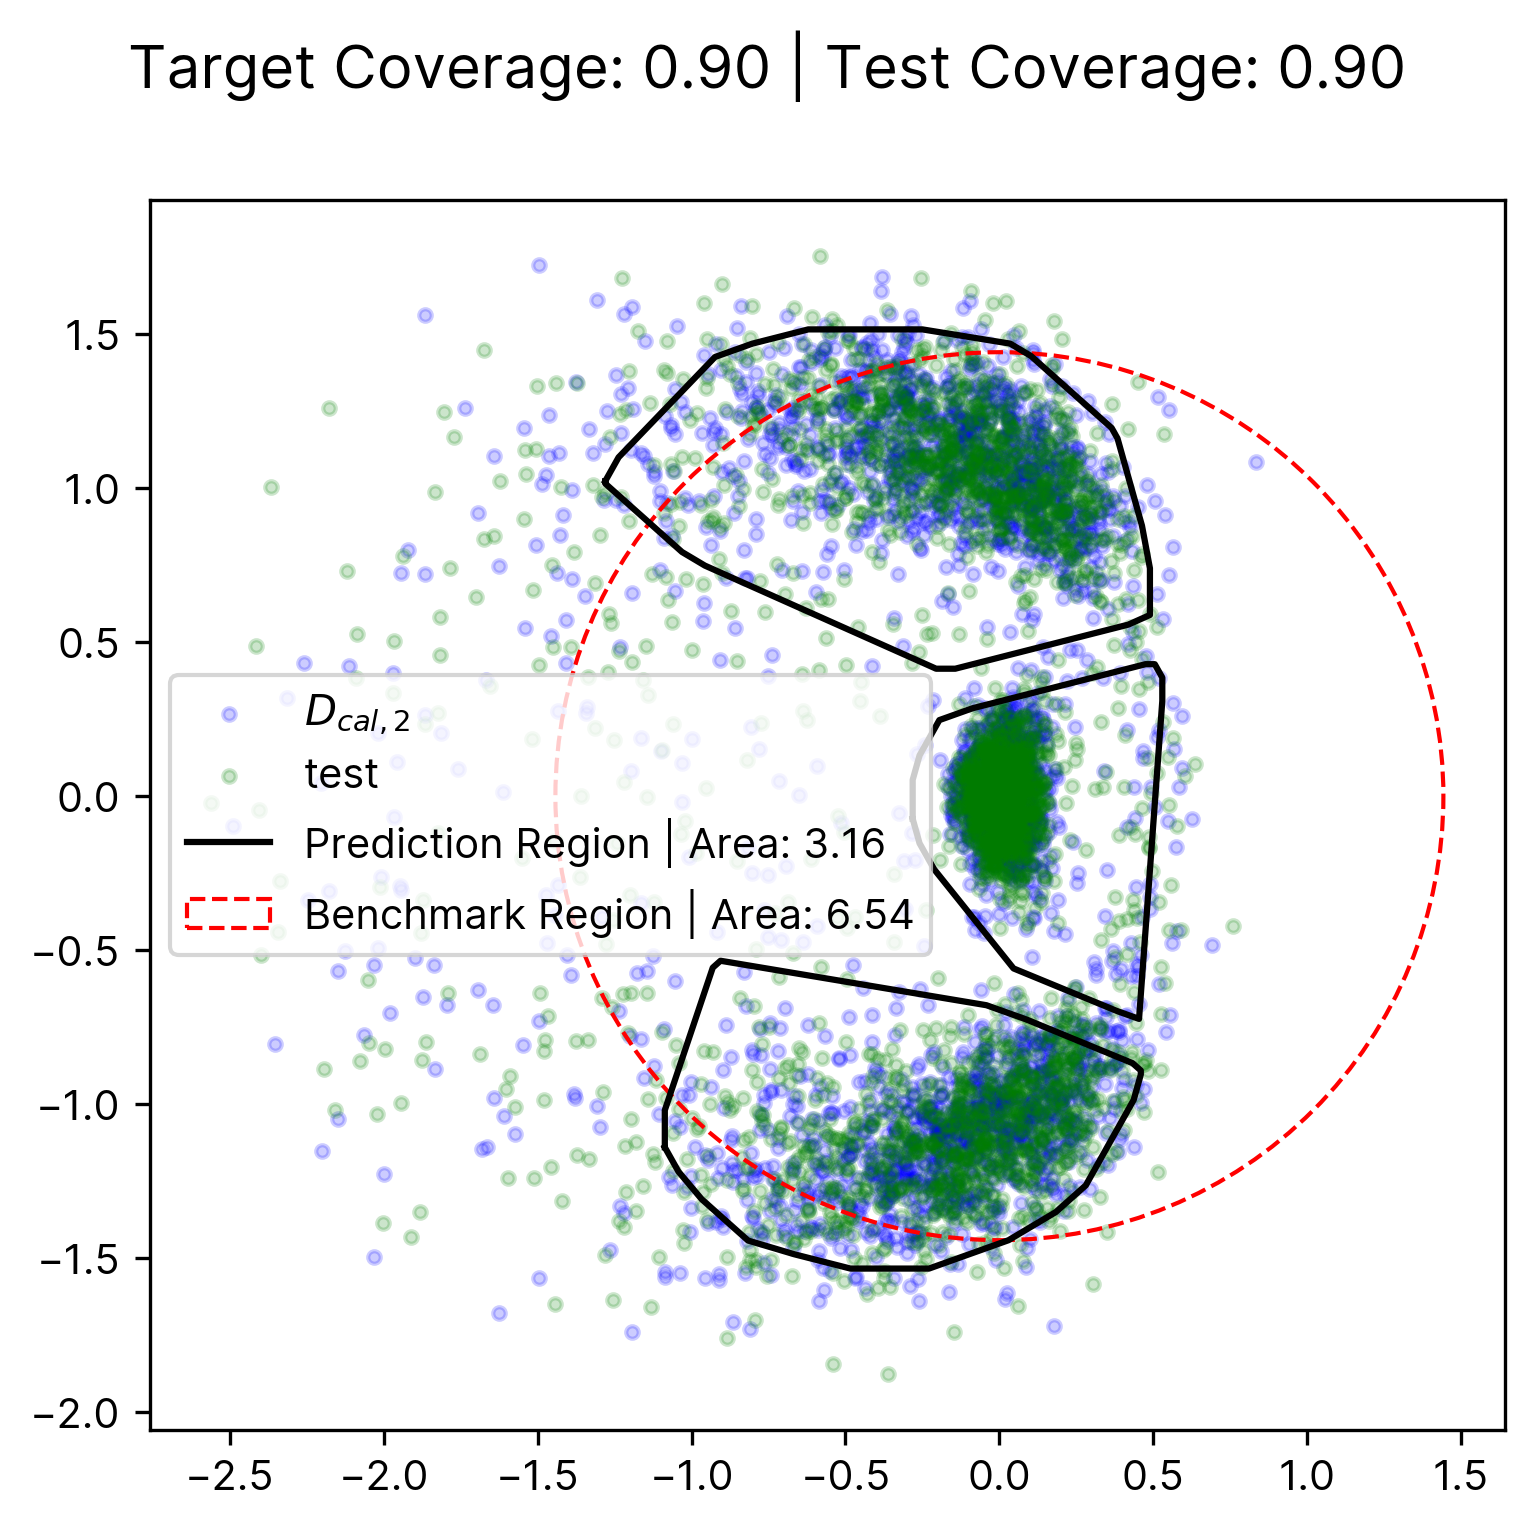

In [13]:
scores = cvxpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
cvx_coverage = coverage

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(cvxpcr.shapes):
    total_area += shape_template.volume()
    if i == len(cvxpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}');


Text(0.5, 0.98, 'Convex Hull Prediction Region for Endpoint')

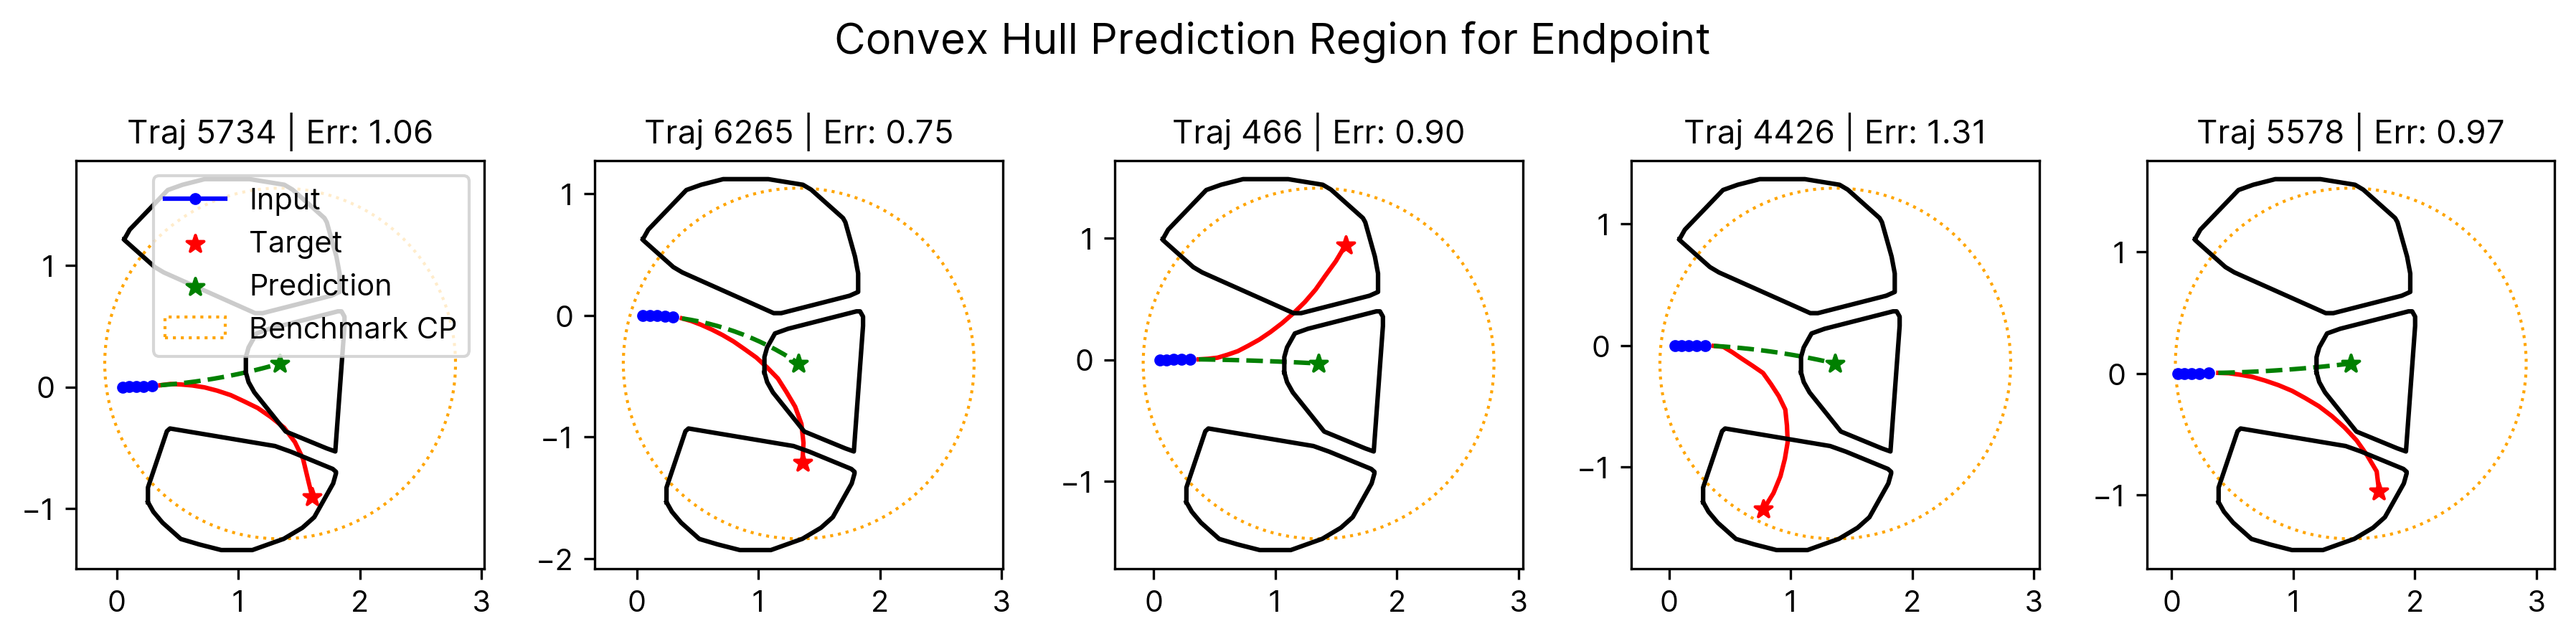

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in cvxpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    # Plot benchmark CP region
    bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    ax.add_patch(bcp_cir)
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Convex Hull Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

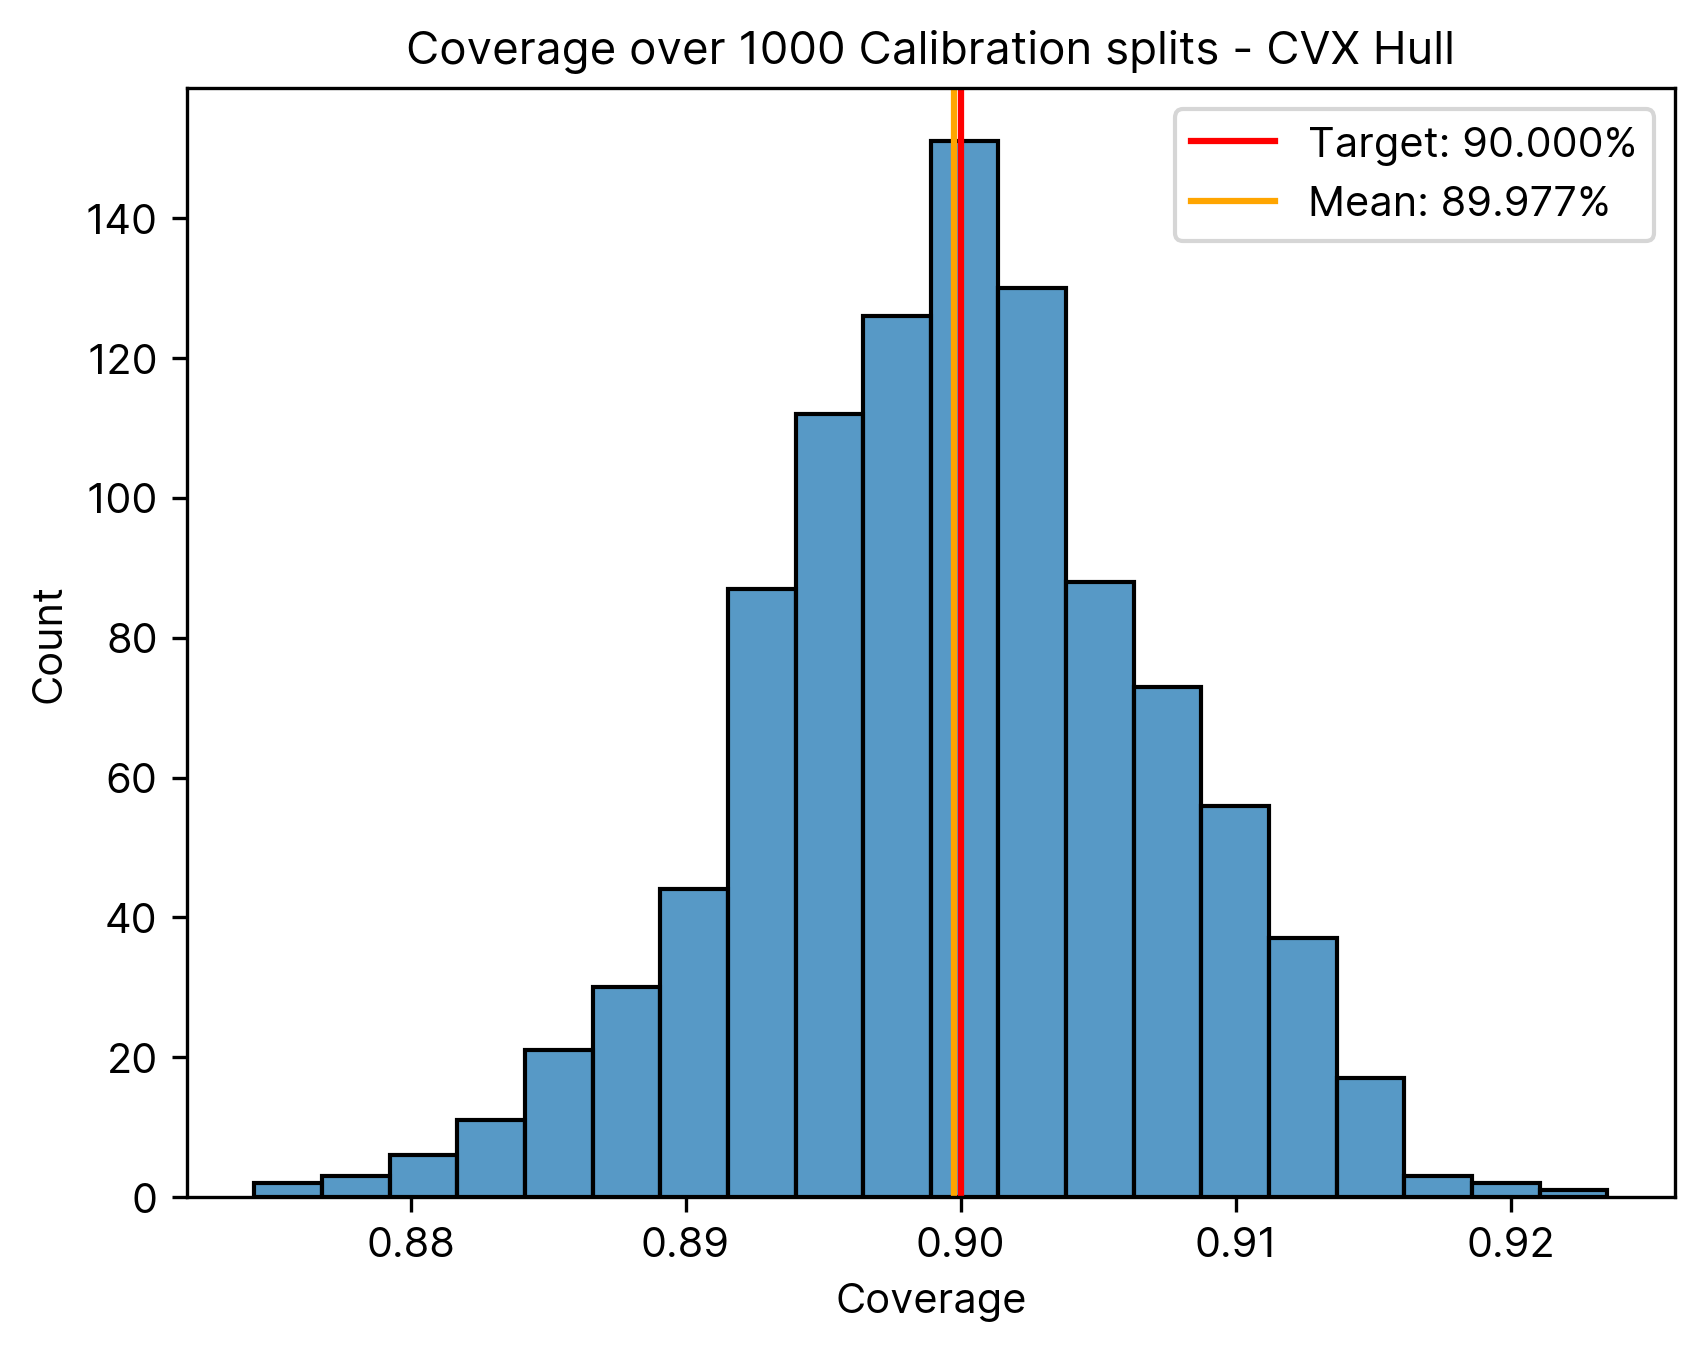

In [15]:
cvxcoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)

sns.histplot(cvxcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(cvxcoverages), color="orange", label=f"Mean: {np.mean(cvxcoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - CVX Hull")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Hyperrectangle

In [16]:
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegion(de, "meanshift", "hyperrectangle", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
hrcpcr = pcr

Total Weight Sum: 0.9867109337192436


Test Coverage:  0.8983203359328135


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.90')

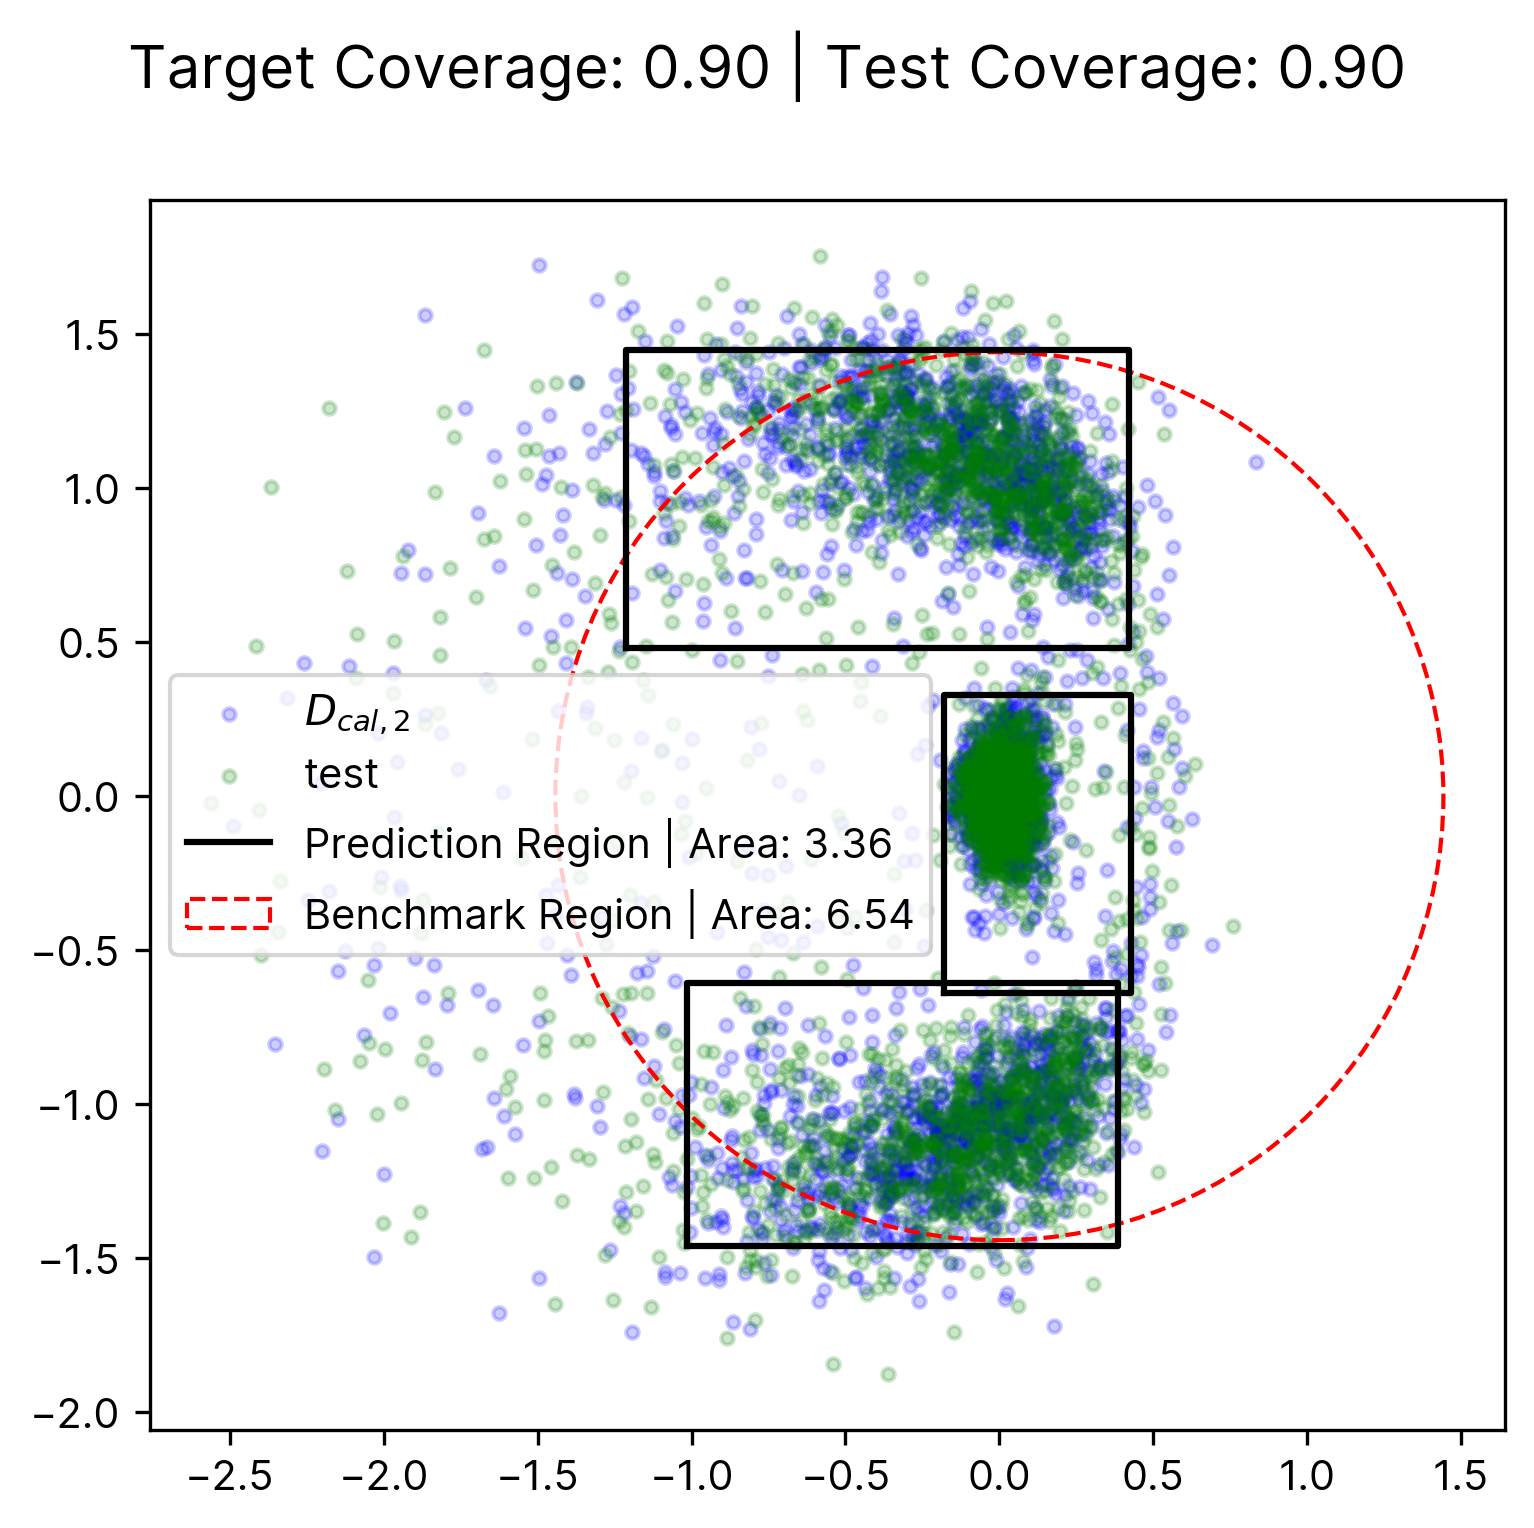

In [17]:
scores = hrcpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
hrc_coverage = coverage

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(hrcpcr.shapes):
    total_area += shape_template.volume()
    if i == len(hrcpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Hyperrectangle Prediction Region for Endpoint')

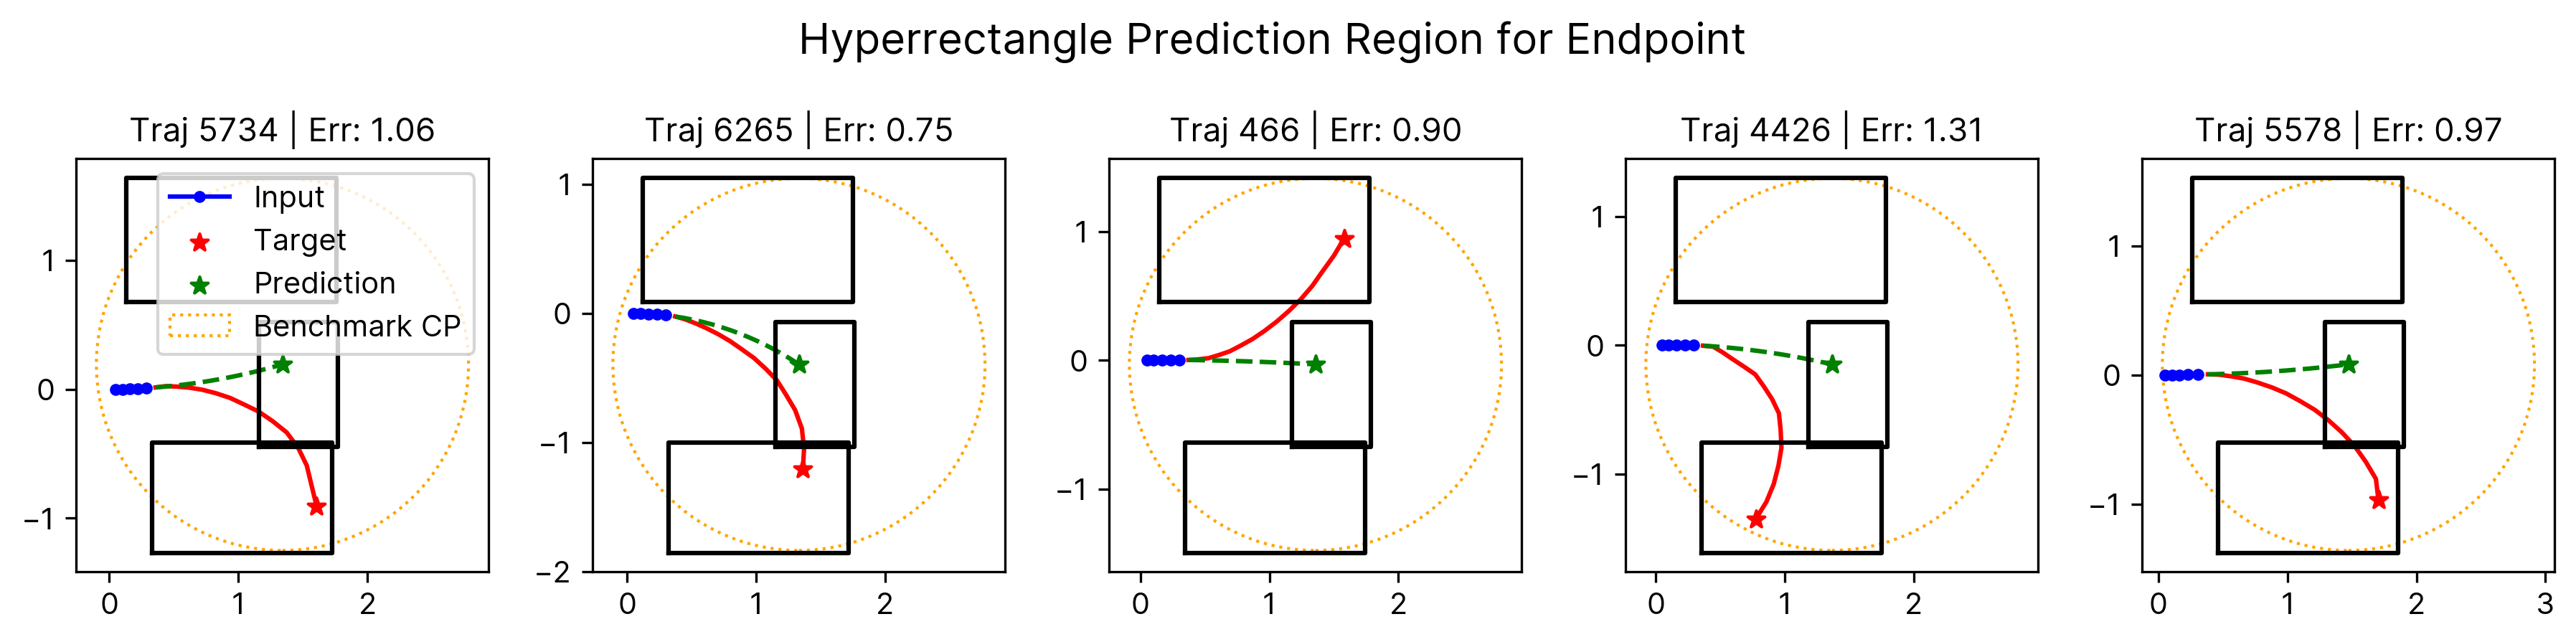

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in hrcpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    # Plot benchmark CP region
    bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    ax.add_patch(bcp_cir)
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Hyperrectangle Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

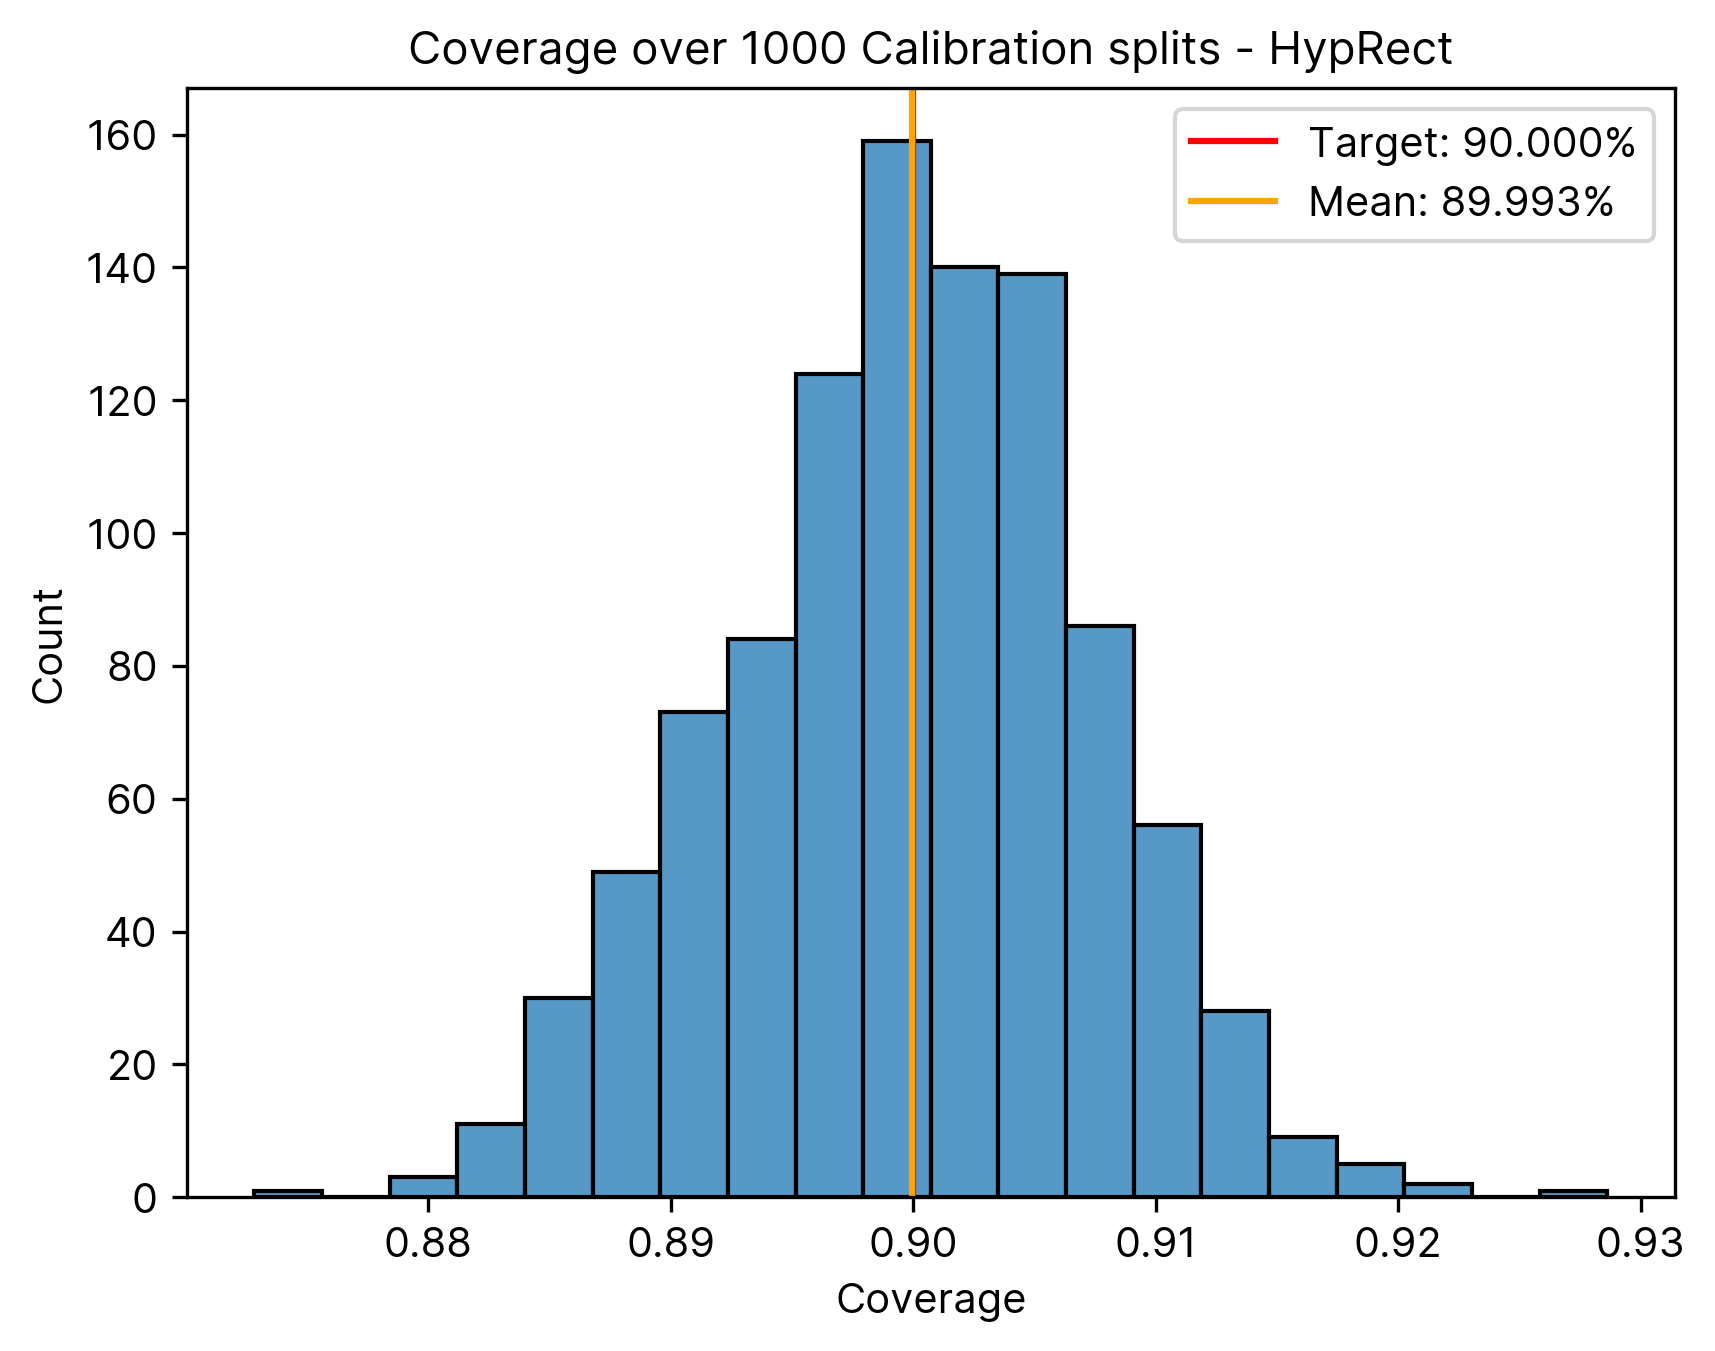

In [19]:
hrccoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(hrccoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(hrccoverages), color="orange", label=f"Mean: {np.mean(hrccoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - HypRect")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Ellipsoid

In [20]:
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegion(de, "meanshift", "ellipse", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
ellpcr = pcr
print(pcr.normalizing_constant)

Total Weight Sum: 0.9867109337192436
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1064819, Sat Nov 25 05:12:17 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.658344338984815e+00 1.0e+00 1.00e+00  9e-01  1e+00 0:00.1
    2     18 4.390382605764453e+00 1.2e+00 9.98e-01  9e-01  1e+00 0:00.1
    3     27 3.027800413342625e+00 1.4e+00 1.01e+00  1e+00  1e+00 0:00.2
   52    468 6.514492497496887e-01 2.5e+01 8.32e-02  6e-03  1e-01 0:03.2
  100    900 6.427635654836936e-01 3.2e+02 7.59e-03  3e-04  2e-02 0:06.2
  181   1629 6.425137888196696e-01 1.0e+04 2.30e-04  5e-06  1e-03 0:11.2
  200   1800 6.425137058519149e-01 2.6e+04 9.56e-05  1e-06  5e-04 0:12.4
  300   2700 6.425136018588452e-01 4.2e+05 6.26e-07  8e-10  4e-06 0:18.6


/usr/local/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=323)
  warnings.warn(msg + ' (' +


  346   3114 6.425136018270340e-01 3.2e+00 7.95e-08  4e-08  1e-07 0:21.5
termination on tolfun=1e-11 (Sat Nov 25 05:12:39 2023)
final/bestever f-value = 6.425136e-01 6.425136e-01 after 3115/3069 evaluations
incumbent solution: [4.765153354015297, 0.6763107640380142, 0.14250036672699196, 8.07579113678365, -0.2945082837075388, 0.9718772109086844]
std deviation: [3.807842113068967e-08, 7.582743931199479e-08, 5.560433281000777e-08, 1.0160360237862828e-07, 7.73178646534248e-08, 5.168369621337941e-08]
[array([[22.72698019,  4.37352525],
       [ 4.37352525, 65.6757622 ]])]
[array([-0.29450828,  0.97187721])]
Soln time: 21.69144296646118
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1037891, Sat Nov 25 05:12:39 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.209041770311468e+00 1.0e+00 1.01e+00  1e+00  1e+00 0:00.1
    2     18 3.108025875741421e+00 1.2e+00 9.89e-01  9e-01  1e+00 0:00.1
    3     27 1.842313659988905e+00 1.3e+00 8.60e-01 

/usr/local/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=313)
  warnings.warn(msg + ' (' +


  325   2925 5.681875589493903e-01 2.4e+00 7.94e-08  5e-08  9e-08 0:16.8
termination on tolfun=1e-11 (Sat Nov 25 05:12:56 2023)
final/bestever f-value = 5.681876e-01 5.681876e-01 after 2926/2885 evaluations
incumbent solution: [1.8057793654734269, 1.8243393528132401, -1.2563853207975626, 2.5335672120563686, -0.36228360066888854, -0.9708390501127724]
std deviation: [6.96961114820786e-08, 5.30774602487589e-08, 7.352767381353347e-08, 9.435893955345699e-08, 6.722700228335677e-08, 8.228287065525349e-08]
[array([[4.83934062, 0.11121851],
       [0.11121851, 9.74717446]])]
[array([-0.36228363, -0.9708391 ])]
Soln time: 17.058351516723633
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1038451, Sat Nov 25 05:12:56 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.192785796051542e+00 1.0e+00 8.39e-01  8e-01  8e-01 0:00.0
    2     18 1.561958921187341e+00 1.1e+00 7.55e-01  7e-01  8e-01 0:00.1
    3     27 1.306886752231665e+00 1.3e+00 6.24e-01 

/usr/local/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=290)
  warnings.warn(msg + ' (' +


  300   2700 4.535363242668564e-01 1.9e+00 3.31e-07  2e-07  3e-07 0:10.2
  343   3087 4.535363242452654e-01 1.1e+01 2.51e-07  9e-08  3e-07 0:11.7
termination on tolfun=1e-11 (Sat Nov 25 05:13:08 2023)
final/bestever f-value = 4.535363e-01 4.535363e-01 after 3088/3059 evaluations
incumbent solution: [3.174243174584433, 0.9719291449036973, -0.8914095885775168, 2.349918114980028, 0.23599679016274422, -0.10070129068489564]
std deviation: [2.876460603259982e-07, 1.9415903725907187e-07, 1.2977810170857962e-07, 2.6251639888590457e-07, 8.655988326967308e-08, 2.2087417710204434e-07]
[array([[10.87043038,  0.99039975],
       [ 0.99039975,  6.46676042]])]
[array([ 0.23599677, -0.10070129])]
Soln time: 11.906065464019775
[0.49460203 0.25047116 0.25492681]


Test Coverage:  0.9100179964007199


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.91')

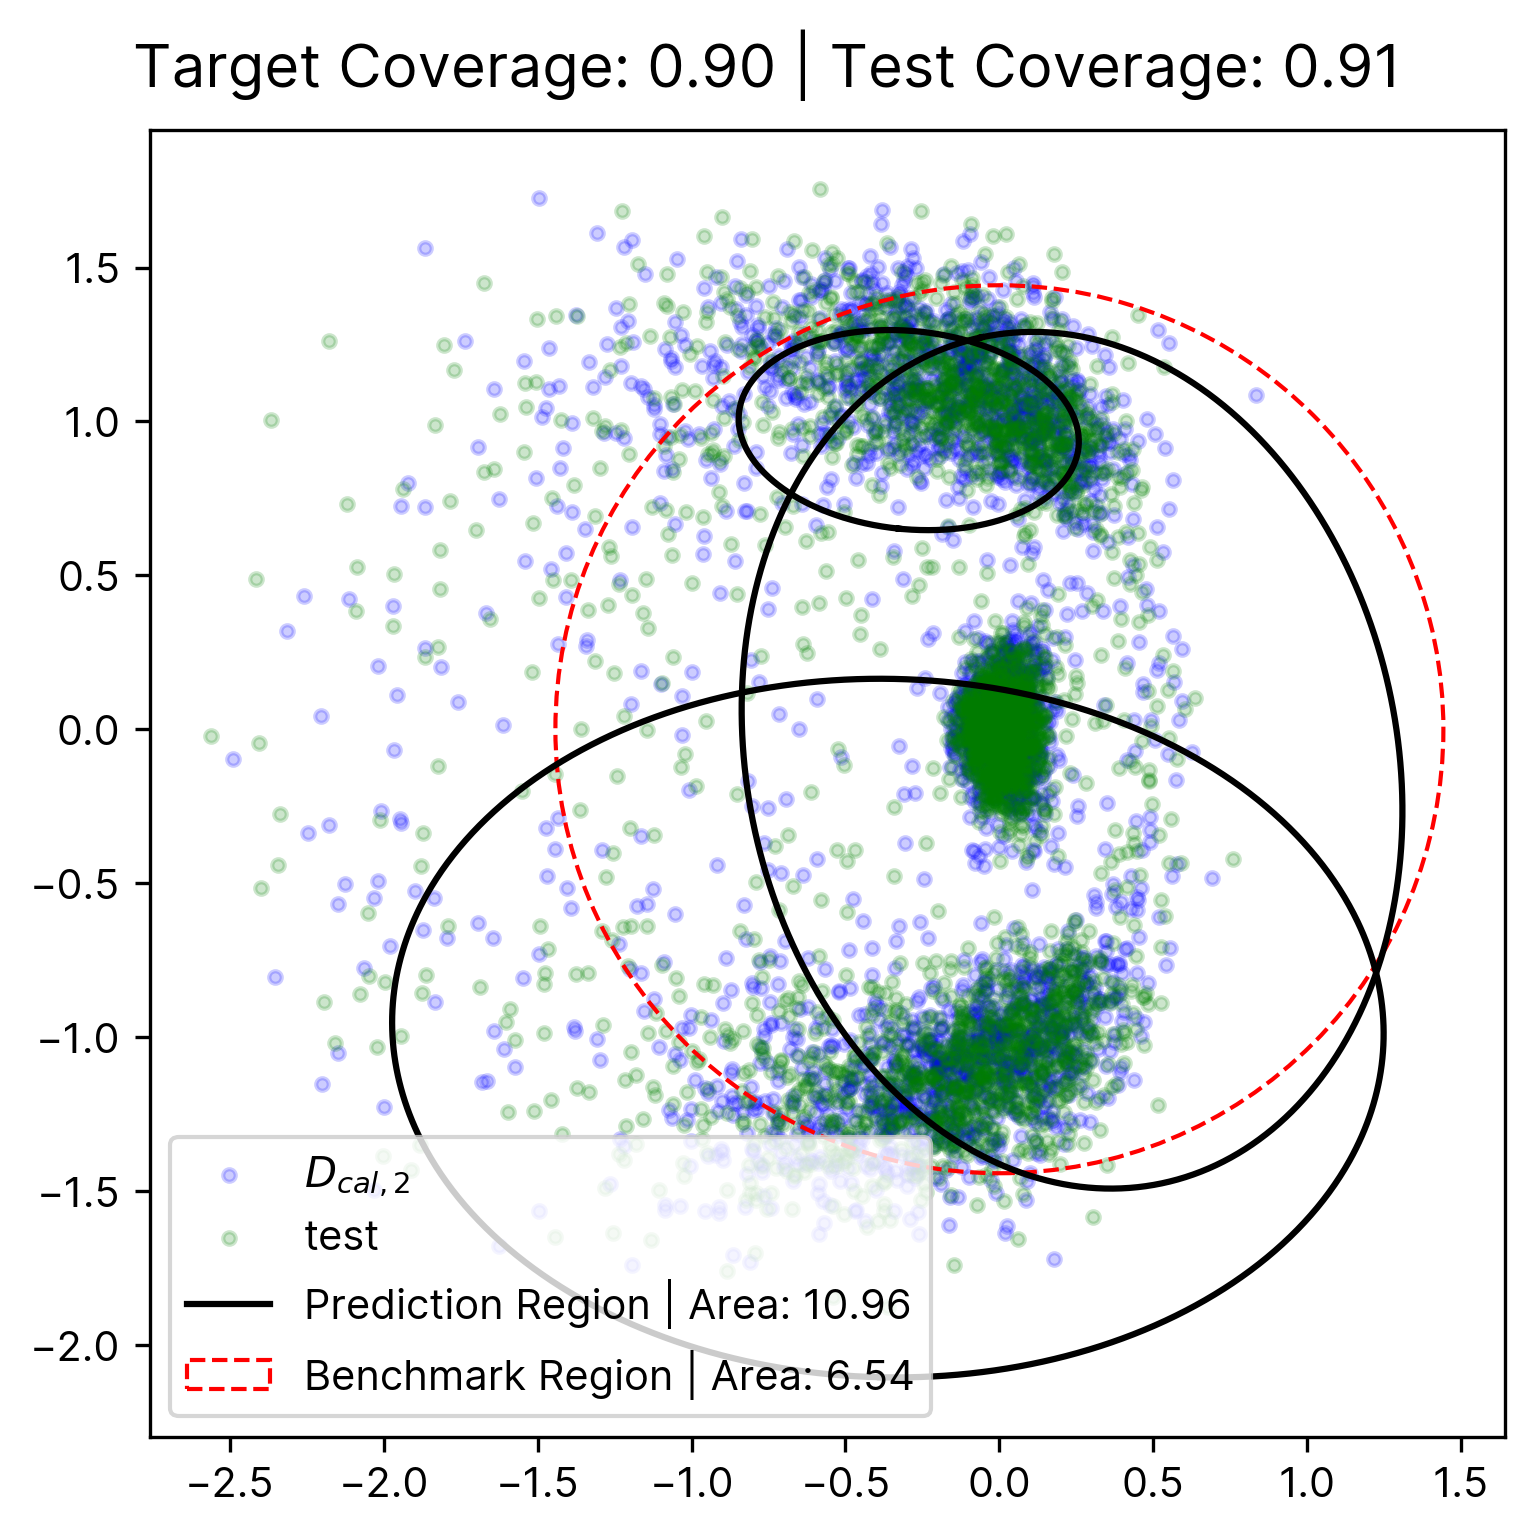

In [21]:
scores = ellpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
ell_coverage = coverage

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(ellpcr.shapes):
    total_area += shape_template.volume()
    if i == len(ellpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Ellipsoid Prediction Region for Endpoint')

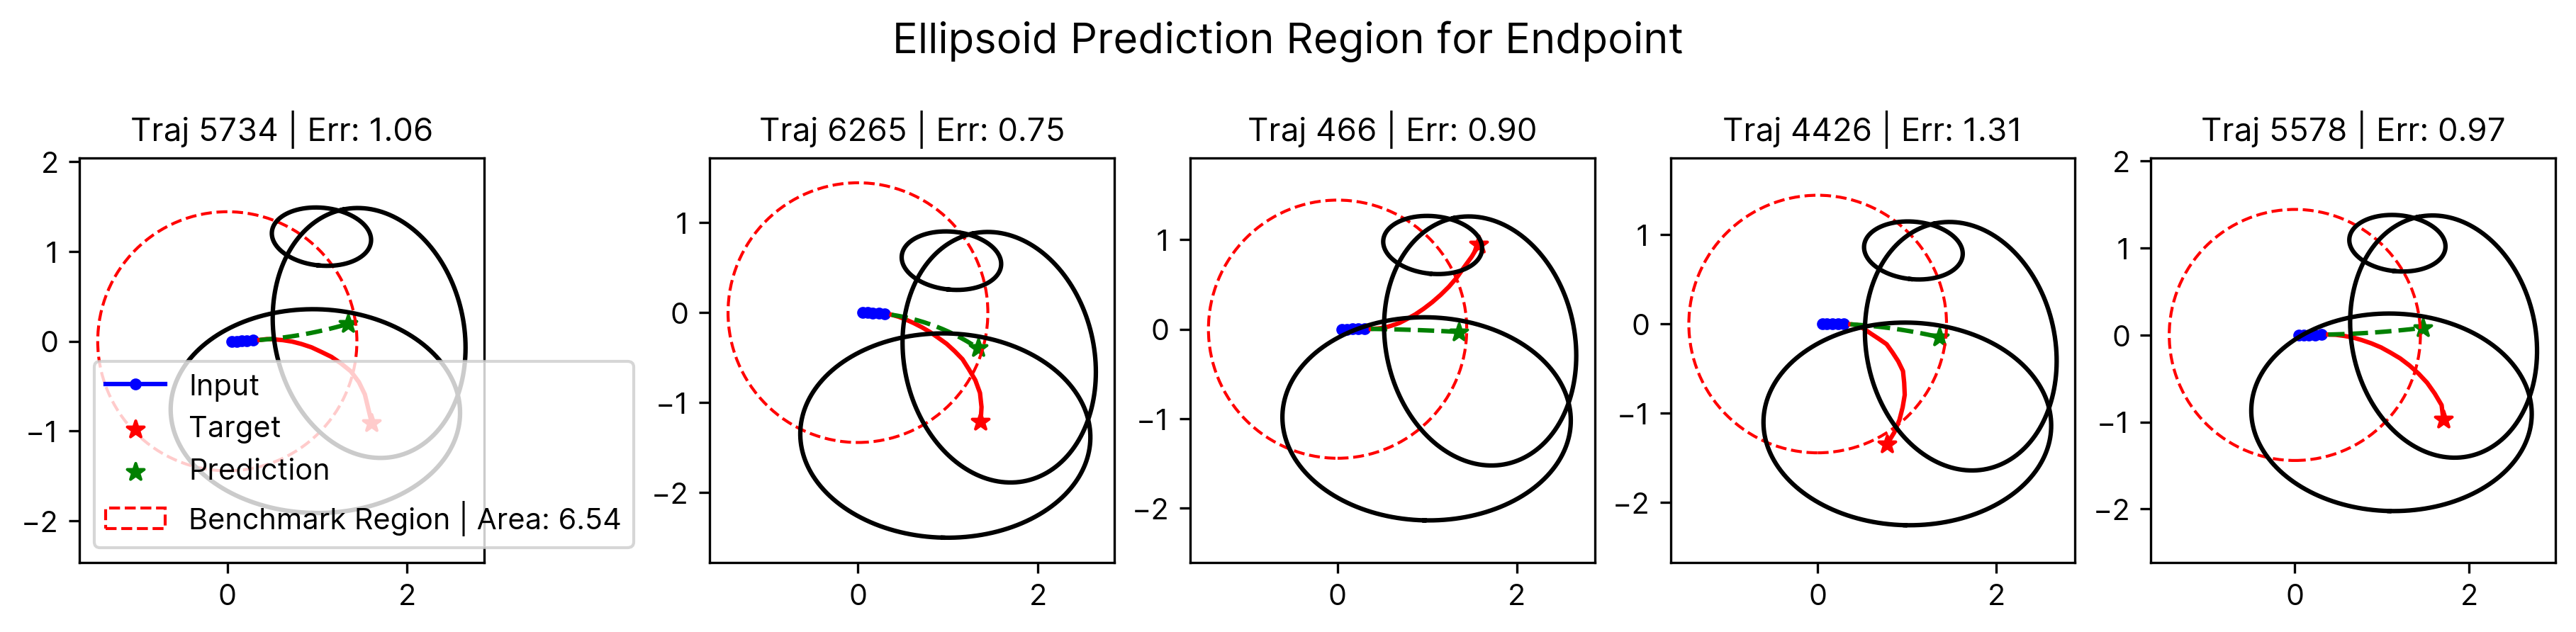

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in ellpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    # Plot benchmark CP region
    bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
    ax.add_patch(bcp_cir)
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Ellipsoid Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

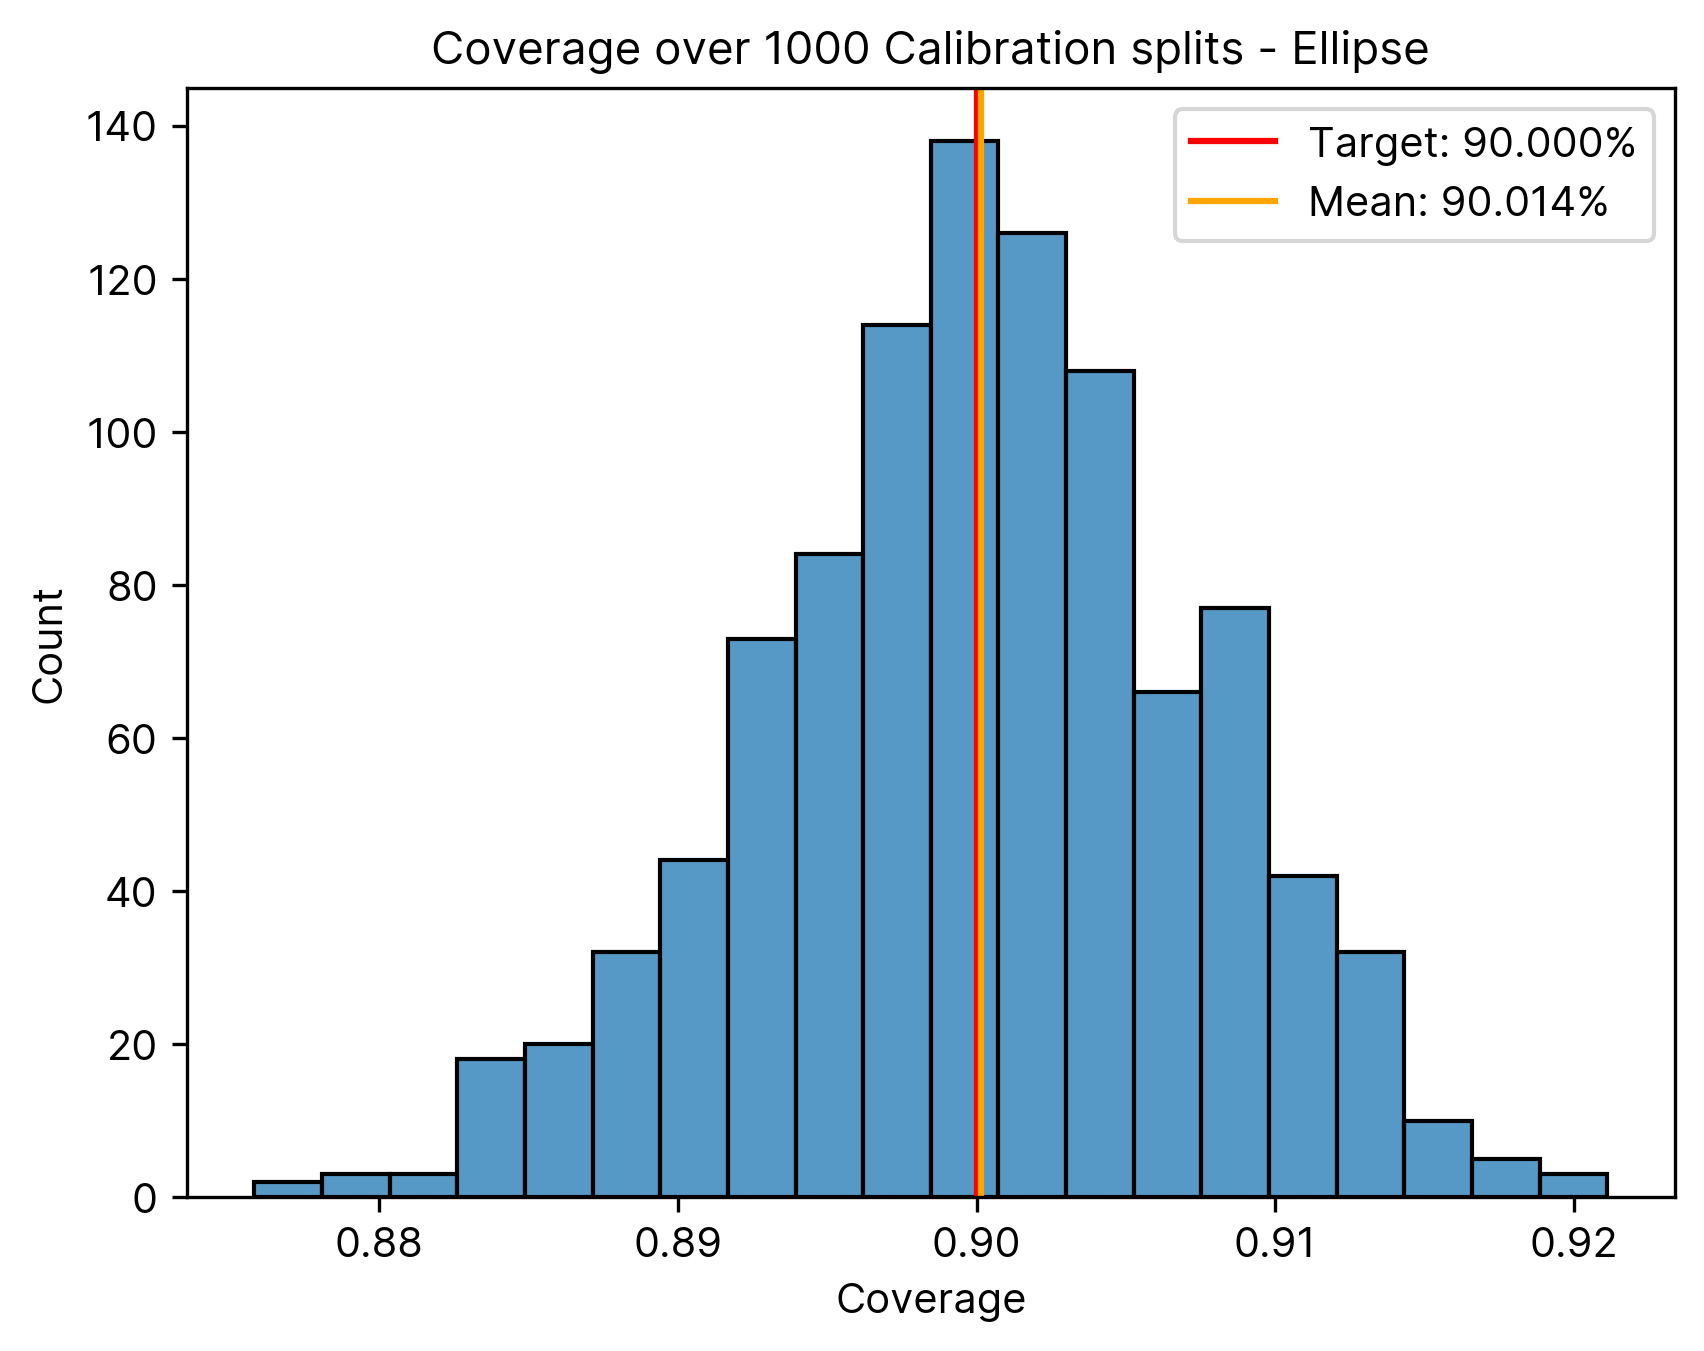

In [23]:
ellcoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(ellcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(ellcoverages), color="orange", label=f"Mean: {np.mean(ellcoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - Ellipse")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

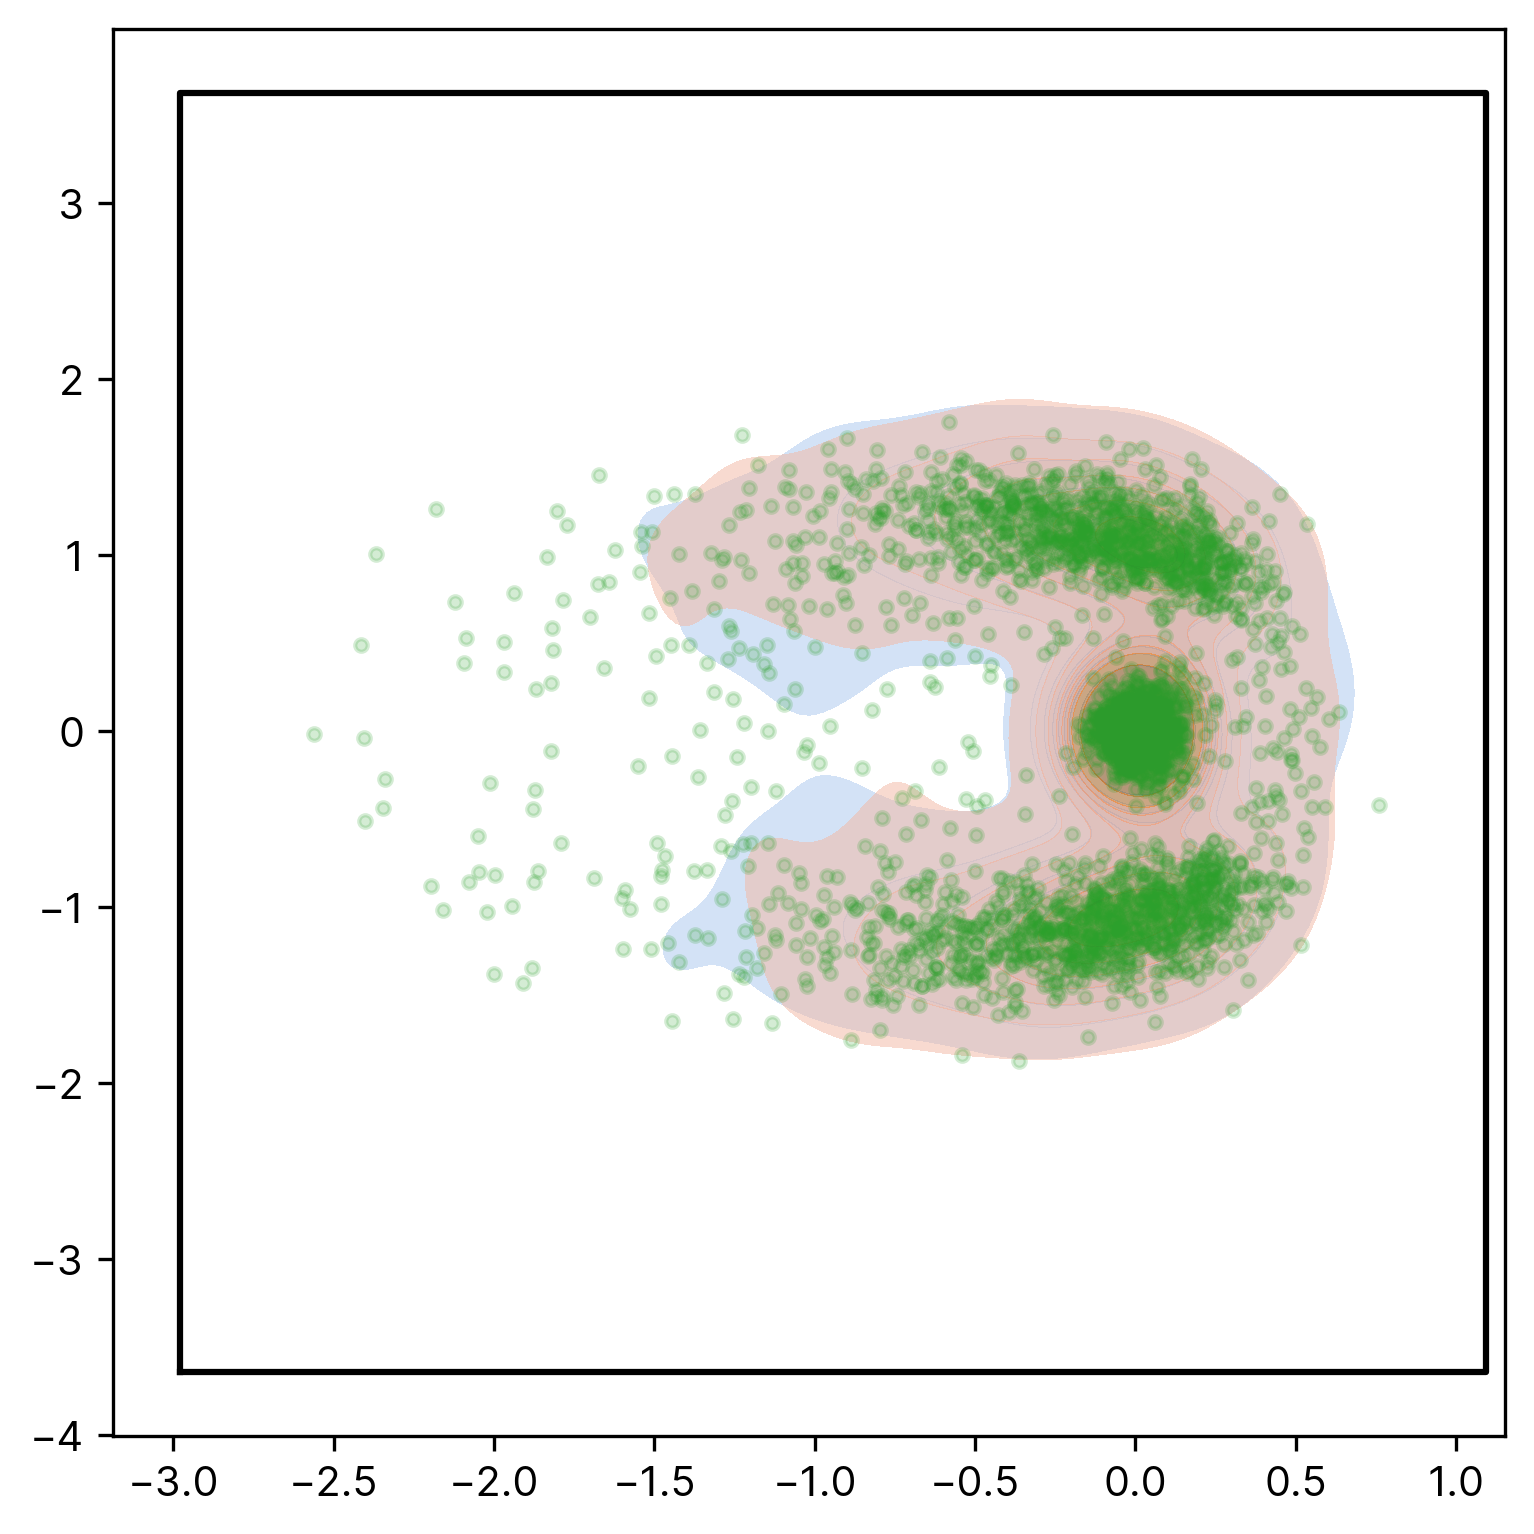

In [24]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
sns.kdeplot(x=Z_cal_one[:,0], y=Z_cal_one[:, 1], fill=True, ax=ax, label='Calibration Set 1', alpha=0.5)
sns.kdeplot(x=Z_cal_two[:,0], y=Z_cal_two[:, 1], fill=True, ax=ax, label='Calibration Set 2', alpha=0.5)
plt.scatter(Z_test[:,0], Z_test[:,1], label='Test Set', alpha=0.2, marker='.')
# Plot the density estimator min and max
ax.plot(
    [pcr.de.min[0], pcr.de.min[0], pcr.de.max[0], pcr.de.max[0], pcr.de.min[0]],
    [pcr.de.min[1], pcr.de.max[1], pcr.de.max[1], pcr.de.min[1], pcr.de.min[1]],
    color="black",
)

Text(0.5, 0.98, 'Vehicle Trajectory Prediction Regions')

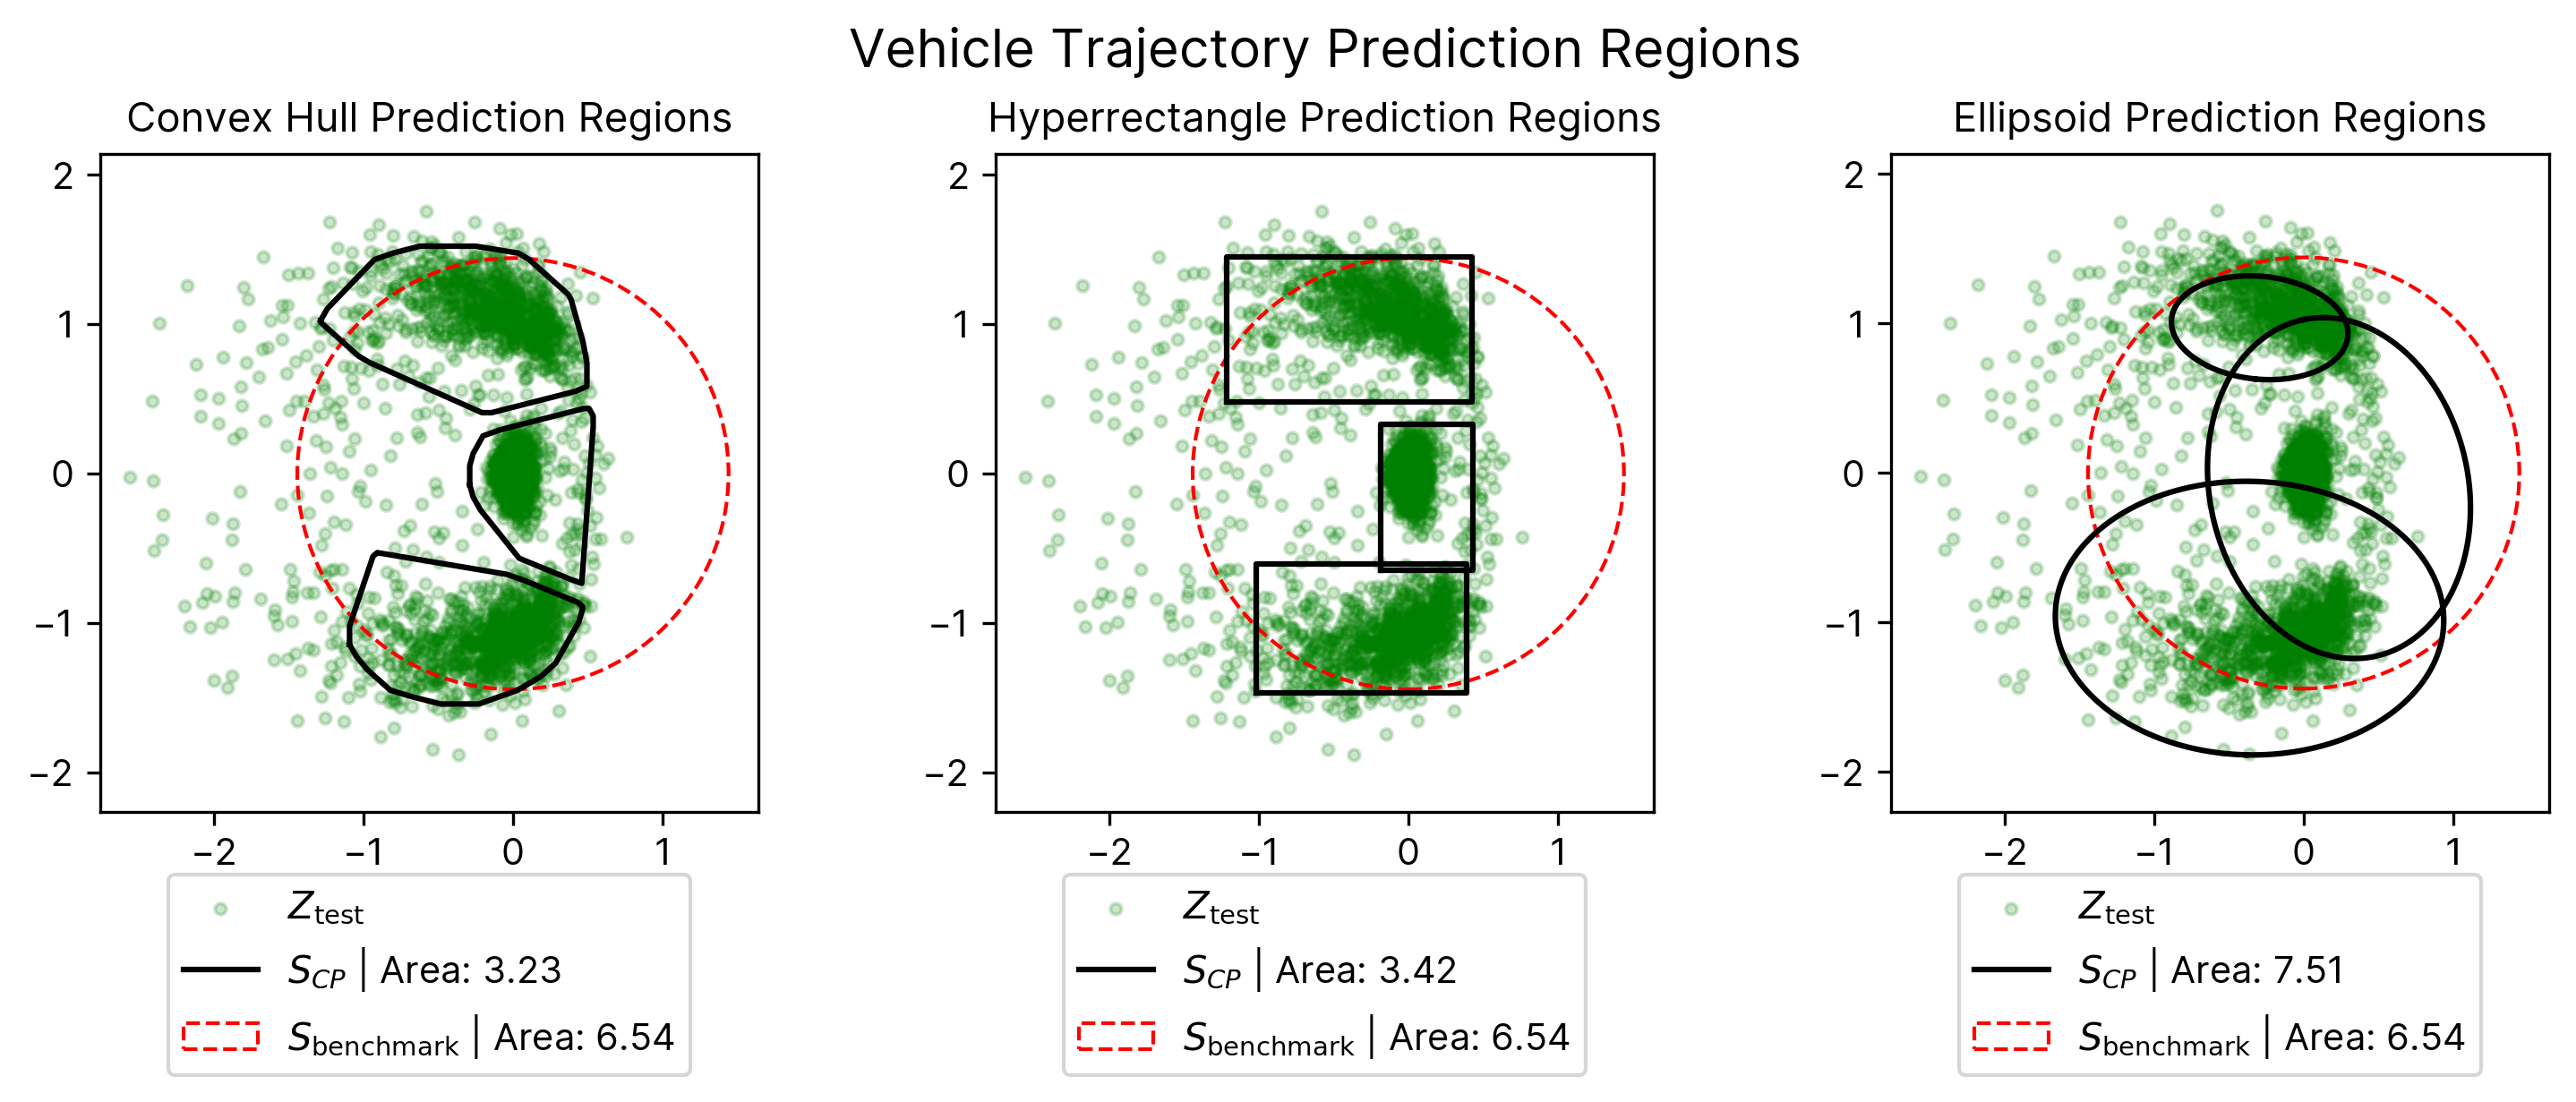

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
# On the first plot, show the convex hull
#ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
axs[0].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[0].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(cvxpcr.shapes):
    total_area += shape_template.volume()
    if i == len(cvxpcr.shapes) - 1:
        shape_template.plot(axs[0], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[0])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[0].add_patch(bcp_cir)
axs[0].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
set_square_aspect_ratio(axs[0])
axs[0].set_title('Convex Hull Prediction Regions')

axs[1].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[1].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(hrcpcr.shapes):
    total_area += shape_template.volume()
    if i == len(hrcpcr.shapes) - 1:
        shape_template.plot(axs[1], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[1])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[1].add_patch(bcp_cir)
axs[1].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
set_square_aspect_ratio(axs[1])
axs[1].set_title('Hyperrectangle Prediction Regions')

axs[2].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[2].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(ellpcr.shapes):
    total_area += shape_template.volume()
    if i == len(ellpcr.shapes) - 1:
        shape_template.plot(axs[2], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[2])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[2].add_patch(bcp_cir)
axs[2].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
axs[2].set_title('Ellipsoid Prediction Regions')
set_square_aspect_ratio(axs[2])

fig.suptitle("Vehicle Trajectory Prediction Regions")

[]

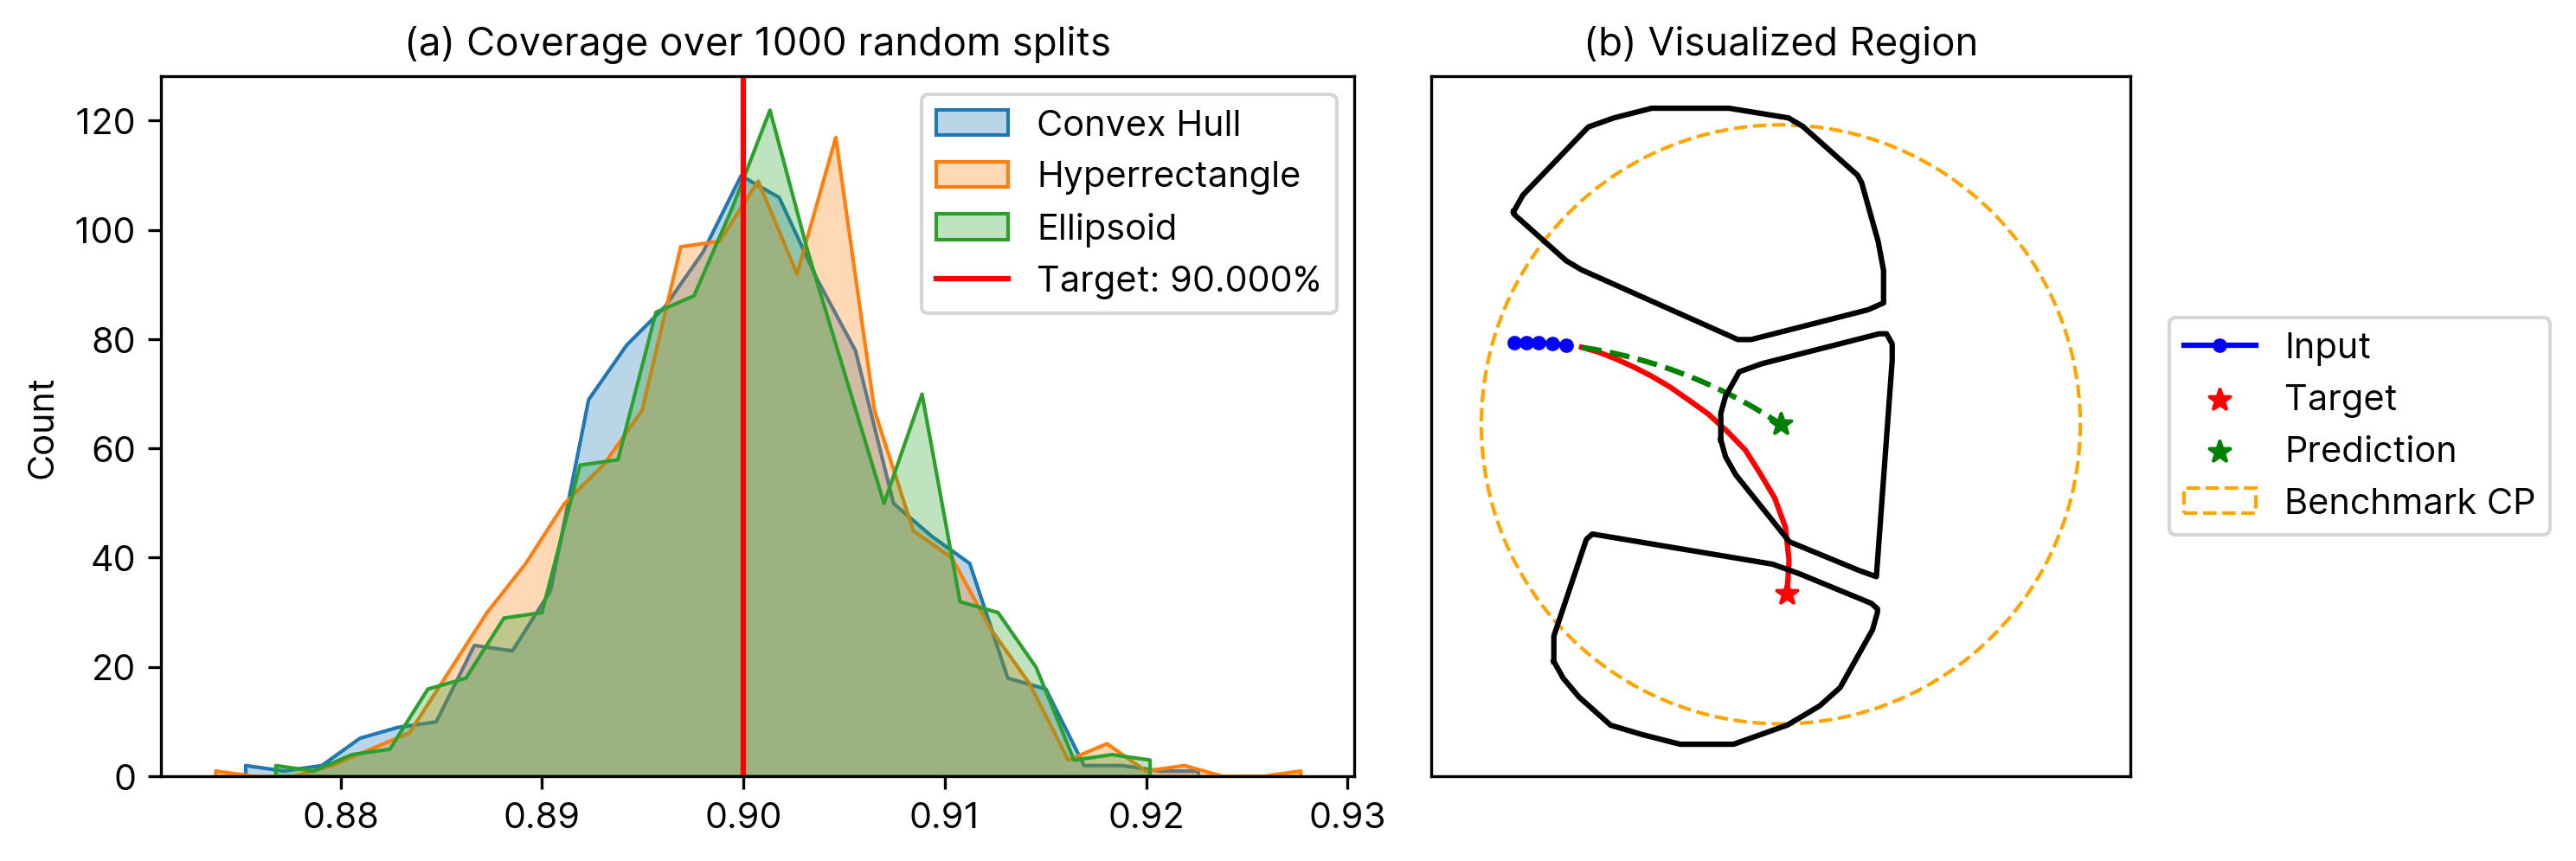

In [68]:
fig = plt.figure(figsize=(10, 3.5))
from matplotlib import gridspec
gs = gridspec.GridSpec(1,10)
ax1 = plt.subplot(gs[0, :6])
ax2 = plt.subplot(gs[0, 6:])

sns.histplot(cvxcoverages, element="poly", label="Convex Hull", alpha=0.3, ax=ax1)
sns.histplot(hrccoverages, element="poly", label="Hyperrectangle", alpha=0.3, ax=ax1)
sns.histplot(ellcoverages, element="poly", label="Ellipsoid", alpha=0.3, ax=ax1)
ax1.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
ax1.legend()
ax1.set_title("(a) Coverage over 1000 random splits")

i=1
prediction = predictor.predict_trajectory(env_X[INDEX[i]])
ax2.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
ax2.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
ax2.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
ax2.plot(prediction[:, 0], prediction[:, 1], 'g--')
ax2.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
for shape_template in cvxpcr.shapes:
    shape_template.plot(ax2, offset_coords=prediction[-1])
ax2.set_title(f'(b) Visualized Region')
# Plot benchmark CP region
bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle='--', fill=False, label='Benchmark CP')
ax2.add_patch(bcp_cir)
set_square_aspect_ratio(ax2)
ax2.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), borderaxespad=0.)
ax2.set_xticks([])
ax2.set_yticks([])
# Zoom out of ax2
# RANGE = 3
# CENTER = [0,-1]
# ax2.set_xlim(CENTER[0]-RANGE, CENTER[0]+RANGE)
# ax2.set_ylim(CENTER[1]-RANGE, CENTER[1]+RANGE)